In [1]:
import anndata
import pandas as pd
import scimap as sm
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

Running SCIMAP  2.1.3


/Users/chiaraschiller/miniconda3/envs/scimap_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
#path_to_csv = './../data/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells.csv'
path_to_csv = './../data/cell_table_final.csv'
obs = pd.read_csv(path_to_csv)

In [4]:
#get the unque values of obs final_cell_type and the count of each class
obs['final_cell_type'].value_counts()

final_cell_type
Cardiomyocytes            323252
Endothelial cells          87804
exclude                    65185
Cardiomyocytes Ankrd1+     64779
Fibroblasts                38328
Mono / Macros Ccr2+        18966
Neutrophils                 9519
Smooth muscle cells         8396
Endocardial cells           5187
Macrophages Trem2+          4206
Other Leukocytes            1776
Macrophages Trem2-           967
Name: count, dtype: int64

In [5]:
obs['fov'].unique()

array(['24h_86', '24h_83', 'Control_13', 'Control_12', '4h_97', '4h_96',
       '48h_79', '48h_76', 'Control_14'], dtype=object)

/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_15026/3492814658.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



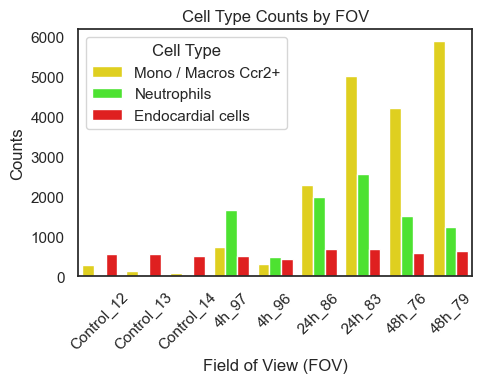

In [6]:
#plot the cell type counts, the fov on the x axis two selected cell types next to each other. On the yaxis the counts

# Your custom order for the FOV
custom_fov_order = ['Control_12', 'Control_13', 'Control_14', '4h_97', '4h_96', '24h_86', '24h_83', '48h_76', '48h_79']  # Example order
# Define custom colors for the selected cell types
cell_type_colors = {
    'Endocardial cells': 'red',  # Blue
    'Mono / Macros Ccr2+': '#FFEA00',  # Orange
    'Neutrophils': '#39FF14'  # Green
}

# Filter for the selected cell types
#selected_cell_types = ['Cardiomyocytes', 'Cardiomyocytes Ankrd1+']
selected_cell_types = ['Endocardial cells', 'Mono / Macros Ccr2+', 'Neutrophils']
#selected_cell_types = ['Neutrophils', 'Smooth muscle cells']
#selected_cell_types = ['Endothelial cells', 'Cardiomyocytes Ankrd1+']
filtered_obs = obs[obs['final_cell_type'].isin(selected_cell_types)]

# Ensure the FOV column is ordered based on the custom vector
filtered_obs['fov'] = pd.Categorical(filtered_obs['fov'], categories=custom_fov_order, ordered=True)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.countplot(
    data=filtered_obs,
    x='fov',  # Field of view on the x-axis
    hue='final_cell_type',  # Cell types shown as different bars
    order=custom_fov_order,  # Reorder FOVs based on the custom vector
    palette=cell_type_colors,  # Set the custom colors
    ax=ax
)

# Customize the plot appearance
ax.set_title("Cell Type Counts by FOV")
ax.set_ylabel("Counts")
ax.set_xlabel("Field of View (FOV)")
plt.xticks(rotation=45)
plt.legend(title="Cell Type")
plt.tight_layout()

#plt.savefig('./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_ct_count_Endocard_neutro_mono.svg', dpi=500)  # Saves the plot as an SVG file

plt.show()

In [7]:
# rename phenotype and neighbor-phenotype column
###TODO get rif of ignore
#exclude certain cell types in obs
ignore_cell_types = ['exclude']
obs = obs[~obs['final_cell_type'].isin(ignore_cell_types)]

In [8]:
obs['final_cell_type'].value_counts()

final_cell_type
Cardiomyocytes            323252
Endothelial cells          87804
Cardiomyocytes Ankrd1+     64779
Fibroblasts                38328
Mono / Macros Ccr2+        18966
Neutrophils                 9519
Smooth muscle cells         8396
Endocardial cells           5187
Macrophages Trem2+          4206
Other Leukocytes            1776
Macrophages Trem2-           967
Name: count, dtype: int64

In [9]:
# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Ensure obs has a string-based index
obs.index = obs.index.astype(str)  # Convert index to string


# Load dataframe into anndata object
# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs
adata

AnnData object with n_obs × n_vars = 563180 × 2
    obs: 'fov', 'label', 'cell_size', 'X_centroid', 'Y_centroid', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster', 'timepoint', 'region', 'region_name', 'refined_cell_type', 'final_cell_type', 'endocardial_annotation', 'exclude_annotation', 'artefact', 'distance_from_lumen', 'lumen_bin', 'size_filter', 'D', 'E'

In [28]:
adata.obs['final_cell_type'].value_counts()

final_cell_type
Cardiomyocytes            323252
Endothelial cells          87804
Cardiomyocytes Ankrd1+     64779
Fibroblasts                38328
Mono / Macros Ccr2+        18966
Neutrophils                 9519
Smooth muscle cells         8396
Endocardial cells           5187
Macrophages Trem2+          4206
Other Leukocytes            1776
Macrophages Trem2-           967
Name: count, dtype: int64

In [10]:
# run spatial interaction analysis
spatial = sm.tl.spatial_interaction (adata,
                         x_coordinate='X_centroid',
                         y_coordinate='Y_centroid',
                         phenotype='final_cell_type',
                         method='knn', 
                         #radius=100, 
                         knn=5,
                         permutation=300,
                         imageid='fov',
                         subset=None,
                         pval_method='zscore',
                         normalization='conditional',
                         verbose=True,
                         #scaling=True,
                         label='dirSEA_knn10')

Processing Image: ['24h_86']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
n_freq: phenotype       neighbour_phenotype   
Cardiomyocytes  Cardiomyocytes            2.932175
                Cardiomyocytes Ankrd1+    1.807541
                Endocardial cells         1.357675
                Endothelial cells         1.270661
                Fibroblasts               1.182415
dtype: float64
mean: 0    2.361203
1    1.274275
2    1.013310
3    1.183143
4    1.095139
dtype: float64
std: 0    0.003384
1    0.003411
2    0.003318
3    0.003191
4    0.002957
dtype: float64
[168.75162949 156.32926852 103.790201    27.42476127  29.51161023]
Processing Image: ['24h_83']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
n_freq: phenotype       neighbour_phenotype   
Cardiomyocytes  Cardiomyocytes  

In [50]:
# save the spatial.uns['dirSEA_knn10'] as .csv file
spatial = adata.uns['dirSEA_knn10']
spatial = pd.DataFrame(spatial)
spatial
spatial.to_csv('./../../MI_heart_paper/2024_results_MI/MI_dirSEA_scimap_knn5.csv')



In [11]:
adata.uns['dirSEA_knn10']

phenotype     neighbour_phenotype  zscore_24h_86  \
0         Cardiomyocytes          Cardiomyocytes     168.751629   
1         Cardiomyocytes  Cardiomyocytes Ankrd1+     156.329269   
2         Cardiomyocytes       Endocardial cells     103.790201   
3         Cardiomyocytes       Endothelial cells      27.424761   
4         Cardiomyocytes             Fibroblasts      29.511610   
..                   ...                     ...            ...   
116  Smooth muscle cells      Macrophages Trem2-      -0.200621   
117  Smooth muscle cells     Mono / Macros Ccr2+       3.611419   
118  Smooth muscle cells             Neutrophils       6.440985   
119  Smooth muscle cells        Other Leukocytes       0.066691   
120  Smooth muscle cells     Smooth muscle cells      45.419050   

     pvalue_24h_86  count_24h_86  zscore_24h_83  pvalue_24h_83  count_24h_83  \
0     0.000000e+00      2.932175     126.265715   0.000000e+00      2.385911   
1     0.000000e+00      1.807541      13.552124   7.696997e-42      1.518868   
2     0.000000e+00      1.357675      74.363487   0.000000e+00      1.330490   
3    1.389873e-165      1.270661      41.217640   0.000000e+00      1.425320   
4    2.043090e-191      1.182415      21.491145  1.884070e-102      1.200164   
..             ...           ...            ...            ...           ...   
116   8.409946e-01      1.000000     -61.295389   0.000000e+00      0.000000   
117   3.045268e-04      1.141667       4.479031   7.498277e-06      1.244726   
118   1.187008e-10      1.180000       3.481756   4.981376e-04      1.142857   
119   9.468280e-01      1.000000      -0.207568   8.355661e-01      1.000000   
120   0.000000e+00      1.948071      38.336318   0.000000e+00      1.855832   

     zscore_Control_13  pvalue_Control_13  ...  count_4h_96  zscore_48h_79  \
0             1.833969       6.665866e-02  ...     2.887037      77.478357   
1             8.287099       1.160443e-16  ...     1.800432      35.703861   
2           108.901989       0.000000e+00  ...     1.295050      66.428147   
3            28.891533      1.525312e-183  ...     1.278559      53.949254   
4            18.763666       1.497090e-78  ...     1.164144      20.152005   
..                 ...                ...  ...          ...            ...   
116         -16.496836       3.866296e-61  ...     0.000000       0.140076   
117          -0.160061       8.728331e-01  ...     1.037037       2.783857   
118          -0.653562       5.133942e-01  ...     1.333333       4.408941   
119           0.112159       9.106976e-01  ...     1.000000       0.431225   
120          32.063347      1.430545e-225  ...     1.847525      40.120055   

     pvalue_48h_79  count_48h_79  zscore_48h_76  pvalue_48h_76  count_48h_76  \
0     0.000000e+00      1.986162     123.341565   0.000000e+00      2.466514   
1    3.443769e-279      1.407992      23.493939  4.704206e-122      1.515354   
2     0.000000e+00      1.273608      38.901121   0.000000e+00      1.231959   
3     0.000000e+00      1.712501      27.105826  8.406459e-162      1.422915   
4     2.584327e-90      1.303200      12.765953   2.540211e-37      1.222252   
..             ...           ...            ...            ...           ...   
116   8.886003e-01      1.000000      -0.038322   9.694311e-01      1.000000   
117   5.371676e-03      1.206107       3.433517   5.958056e-04      1.280303   
118   1.038773e-05      1.120000       0.324178   7.458029e-01      1.076923   
119   6.663046e-01      1.027027       3.969386   7.205800e-05      1.107143   
120   0.000000e+00      1.781575      26.082971  5.688971e-150      1.700461   

     zscore_Control_14  pvalue_Control_14  count_Control_14  
0            68.295132       0.000000e+00          3.418681  
1             6.856978       7.033230e-12          1.018519  
2           144.245810       0.000000e+00          1.352147  
3            24.408063      1.404249e-131          1.195804  
4            27.357977      8.679383e-165

They chose radius of 125 mu for MISTy

In [12]:
#only include columns with zscore and replace the zscore_ with empty string
spatial = adata.uns['dirSEA_knn10']
spatial = pd.DataFrame(spatial)

spatial['interaction'] = spatial['neighbour_phenotype'] + '_' + spatial['phenotype']
# remove the two columns
spatial = spatial.drop(columns=['phenotype', 'neighbour_phenotype'])
spatial = spatial.set_index('interaction')

spatial = spatial.filter(like='zscore_', axis=1)
spatial.columns = spatial.columns.str.replace('zscore_', '')

# concatenate the phenotype and neighbor_phenotype column with a "_" in between
#
# make the interaction column the rownames for then saving it as a .csv file
#spatial = spatial.set_index('interaction')
# save the spatial.uns['dirSEA_knn10'] as .csv file
#spatial.T.to_csv('./../../MI_heart_paper/2024_results_MI/MI_SEA_scimap_knn5.csv')

spatial

24h_86      24h_83  Control_13  \
interaction                                                                   
Cardiomyocytes_Cardiomyocytes            168.751629  126.265715    1.833969   
Cardiomyocytes Ankrd1+_Cardiomyocytes    156.329269   13.552124    8.287099   
Endocardial cells_Cardiomyocytes         103.790201   74.363487  108.901989   
Endothelial cells_Cardiomyocytes          27.424761   41.217640   28.891533   
Fibroblasts_Cardiomyocytes                29.511610   21.491145   18.763666   
...                                             ...         ...         ...   
Macrophages Trem2-_Smooth muscle cells    -0.200621  -61.295389  -16.496836   
Mono / Macros Ccr2+_Smooth muscle cells    3.611419    4.479031   -0.160061   
Neutrophils_Smooth muscle cells            6.440985    3.481756   -0.653562   
Other Leukocytes_Smooth muscle cells       0.066691   -0.207568    0.112159   
Smooth muscle cells_Smooth muscle cells   45.419050   38.336318   32.063347   

                                         Control_12       4h_97       4h_96  \
interaction                                                                   
Cardiomyocytes_Cardiomyocytes             36.455950  100.487210  157.984818   
Cardiomyocytes Ankrd1+_Cardiomyocytes     29.750210  111.809332   72.083171   
Endocardial cells_Cardiomyocytes         122.416322  111.473885   77.834614   
Endothelial cells_Cardiomyocytes          21.197509   26.829928   29.708146   
Fibroblasts_Cardiomyocytes                29.495158   18.155951   23.696267   
...                                             ...         ...         ...   
Macrophages Trem2-_Smooth muscle cells     3.464583   -0.115756   -2.507777   
Mono / Macros Ccr2+_Smooth muscle cells   -0.020884    7.476495    1.081229   
Neutrophils_Smooth muscle cells           -1.312065   10.789913   13.280301   
Other Leukocytes_Smooth muscle cells       1.118684   -0.165248   -0.186310   
Smooth muscle cells_Smooth muscle cells   13.708883   42.447524   35.799266   

                                            48h_79      48h_76  Control_14  
interaction                                                                 
Cardiomyocytes_Cardiomyocytes            77.478357  123.341565   68.295132  
Cardiomyocytes Ankrd1+_Cardiomyocytes    35.703861   23.493939    6.856978  
Endocardial cells_Cardiomyocytes         66.428147   38.901121  144.245810  
Endothelial cells_Cardiomyocytes         53.949254   27.105826   24.408063  
Fibroblasts_Cardiomyocytes               20.152005   12.765953   27.357977  
...                                            ...         ...         ...  
Macrophages Trem2-_Smooth muscle cells    0.140076   -0.038322   -0.365267  
Mono / Macros Ccr2+_Smooth muscle cells   2.783857    3.433517   -0.114548  
Neutrophils_Smooth muscle cells           4.408941    0.324178   -1.025319  
Other Leukocytes_Smooth muscle cells      0.431225    3.969386    0.669162  
Smooth muscle cells_Smooth muscle cells  40.120055   26.082971   48.927730  

[121 rows x 9 columns]

In [11]:
adata.obs.region_name.unique()

array(['other_cardiac_tissue', 'border_zone', 'remote_endocardial_region',
       'infarct_core', 'endocardial_region', 'epicardial_region'],
      dtype=object)

In [55]:
adata.obs.keys()

Index(['fov', 'label', 'cell_size', 'X_centroid', 'Y_centroid', 'Eccentricity',
       'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster',
       'refined_cell_type', 'lumen_layer', 'background_layer', 'region',
       'region_name', 'closest_type', 'min_endothelial_distance',
       'min_endocardial_distance', 'timepoint', 'distance_from_lumen', 'D',
       'E'],
      dtype='object')

In [39]:
#get column names of spatial.uns['dirSEA_knn10']
spatial.obs['region_name'].value_counts()


region_name
other_cardiac_tissue         355444
infarct_core                  94551
border_zone                   80395
endocardial_region            14698
epicardial_region             11592
remote_endocardial_region      6500
Name: count, dtype: int64

In [15]:
spatial.uns['dirSEA_knn10']

AttributeError: 'DataFrame' object has no attribute 'uns'

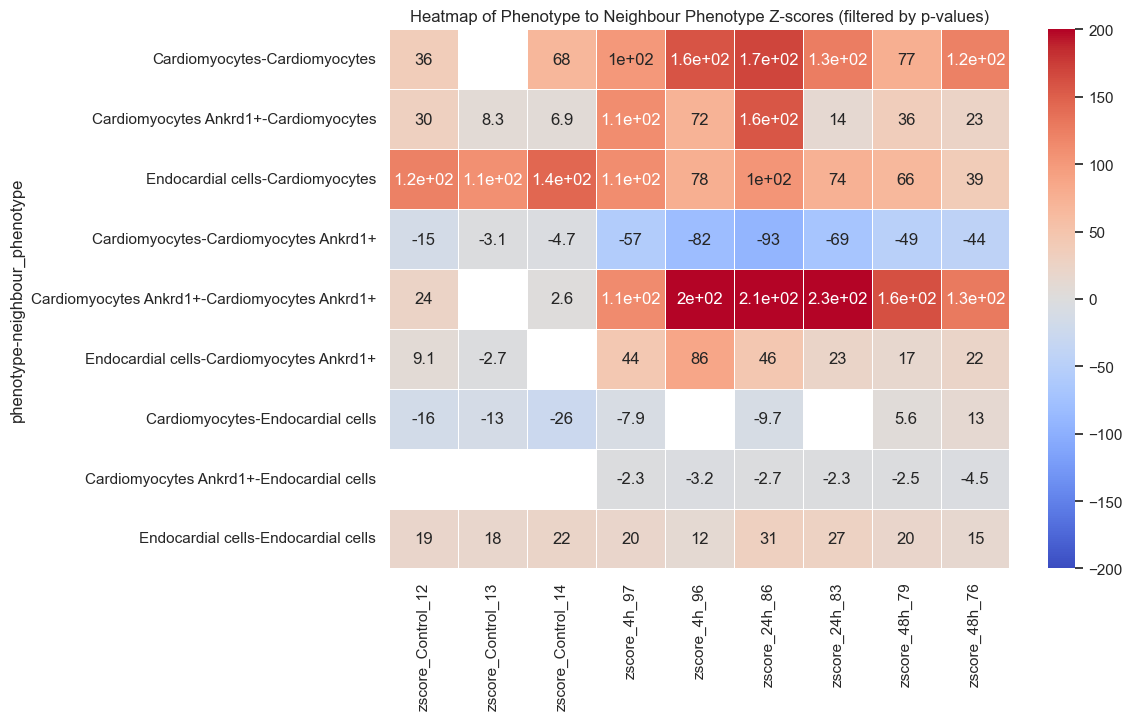

In [16]:
### create user-defined heatmap for basic avoidance and co-localization

# Define data and parameters
df = adata.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05

# reorder samples on the heatmap x axis accordingly
column_order = [
                'zscore_Control_12', 
                'zscore_Control_13',
                'zscore_Control_14',
                'zscore_4h_97', 
                'zscore_4h_96', 
                'zscore_24h_86', 
                'zscore_24h_83', 
                'zscore_48h_79', 
                'zscore_48h_76']  

# column_order = [
#                 'Control_12', 
#                 'Control_13',
#                 'Control_14',
#                 '4h_97', 
#                 '4h_96', 
#                 '24h_86', 
#                 '24h_83', 
#                 '48h_79', 
#                 '48h_76']  

# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
#heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype'])
#reorder columns
heatmap_data = heatmap_data[column_order]


# Set the min and max z-scores in the filtered data
vmin = -200 # set based on your dataset's minimum z-score
vmax = 200   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(10, 7))
#sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax, annot=True, fmt=".0f")
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax, annot=True)
plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
plt.show()


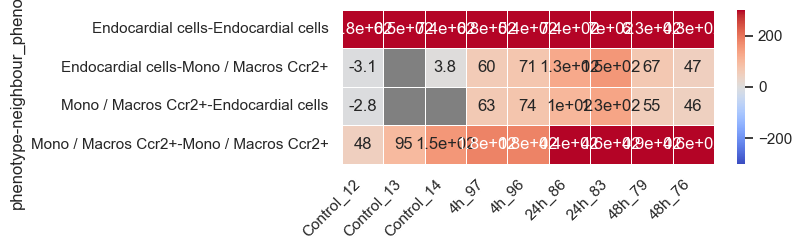

In [10]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
pval_threshold = 0.05

# Switching the column names to have directionality that the first cell is surrounded by the second cell, which means the second cell has a preference for the first cell
#df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})

# reorder samples on the heatmap x axis accordingly
# column_order = [
#     'zscore_Control_12', 'zscore_Control_13', 'zscore_Control_14',
#     'zscore_4h_97', 'zscore_4h_96', 'zscore_24h_86', 'zscore_24h_83',
#     'zscore_48h_79', 'zscore_48h_76'
# ]

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes
#phenotypes_to_include = ['Endocardial cells', 'Neutrophils']  # Update this list with your specific phenotypes
#phenotypes_to_include = ['Endothelial cells', 'Cardiomyocytes Ankrd1+']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]

# Filter the z-scores based on p-values (set to NaN if p-value < threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold,
                                    df_filtered[col], np.nan)

# Filter only the zscore columns
# heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype'
#                                      ]).filter(like='zscore')
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype'
                                      ])

#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'zscore_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

### PLOTTING
# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray

# Set the min and max z-scores in the filtered data
vmin = -300 # set based on your dataset's minimum z-score
vmax = 300   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


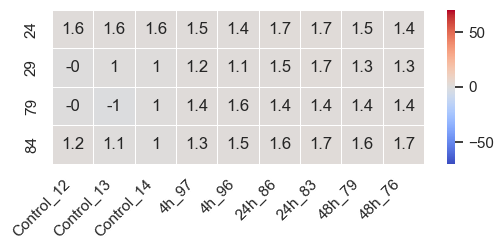

In [64]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
pval_threshold = 0.05

# Switching the column names to have directionality that the first cell is surrounded by the second cell, which means the second cell has a preference for the first cell
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})

# reorder samples on the heatmap x axis accordingly
column_order = [
    'Control_12', 'Control_13', 'Control_14',
    '4h_97', '4h_96', '24h_86', '24h_83',
    '48h_79', '48h_76'
]

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]

# Filter the z-scores based on p-values (set to NaN if p-value < threshold)
#for col in df.columns:
#    if col.startswith('zscore'):
#        pval_col = col.replace('zscore', 'pvalue')
##        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold,
 #                                   df_filtered[col], np.nan)

# Filter only the zscore columns
heatmap_data = df_filtered.loc[:, column_order]

#reorder columns
heatmap_data = heatmap_data[column_order]

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

### PLOTTING
# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray

# Set the min and max z-scores in the filtered data
vmin = -70 # set based on your dataset's minimum z-score
vmax = 70   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


# Endocardial cells

/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_96956/1837392629.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



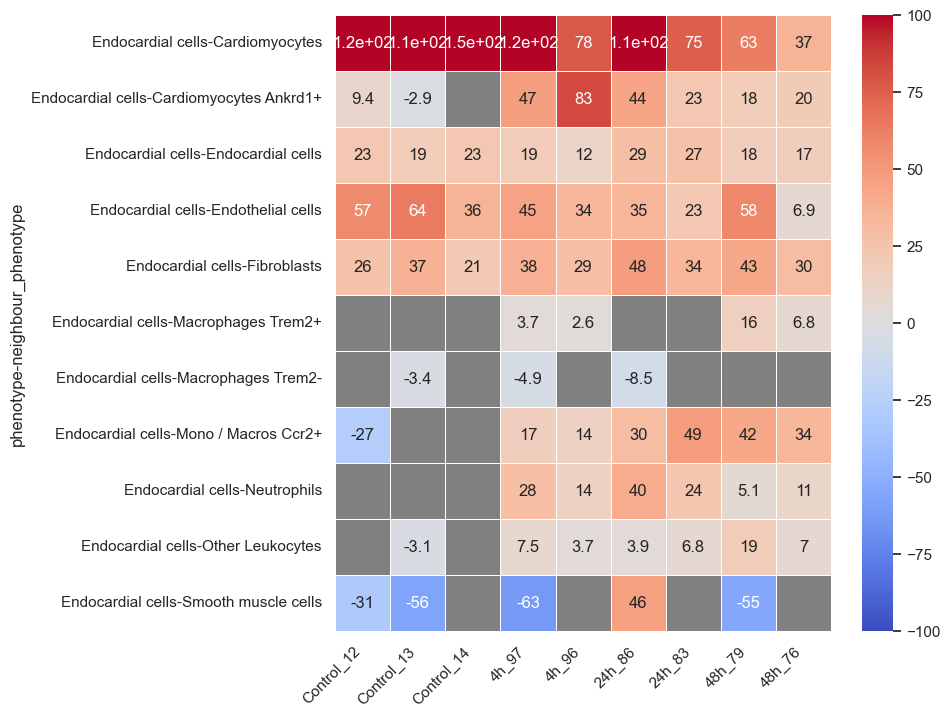

In [51]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05

# reorder samples on the heatmap x axis accordingly
column_order = [
                'zscore_Control_12',
                'zscore_Control_13',
                'zscore_Control_14',
                'zscore_4h_97',
                'zscore_4h_96',
                'zscore_24h_86',
                'zscore_24h_83',
                'zscore_48h_79',
                'zscore_48h_76']

# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Endocardial cells']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
#df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -100 # set based on your dataset's minimum z-score
vmax = 100   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_96956/1843001519.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



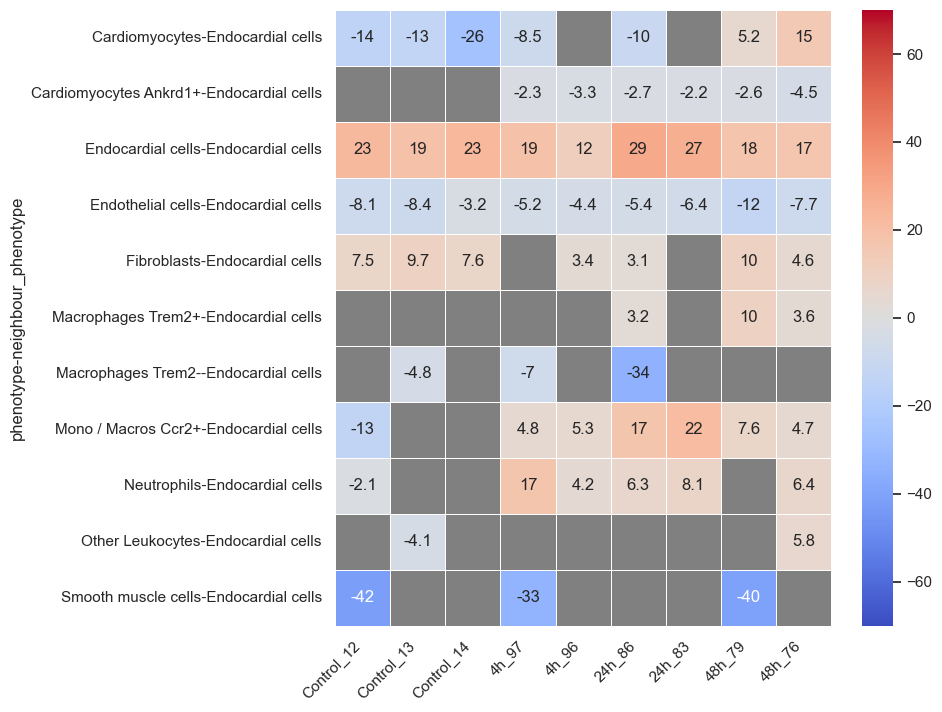

In [52]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05

# reorder samples on the heatmap x axis accordingly
column_order = [
                'zscore_Control_12',
                'zscore_Control_13',
                'zscore_Control_14',
                'zscore_4h_97',
                'zscore_4h_96',
                'zscore_24h_86',
                'zscore_24h_83',
                'zscore_48h_79',
                'zscore_48h_76']

# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Endocardial cells']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
#df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df[df['neighbour_phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -70 # set based on your dataset's minimum z-score
vmax = 70   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


# Mono Macro cells

/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_96956/1460467238.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



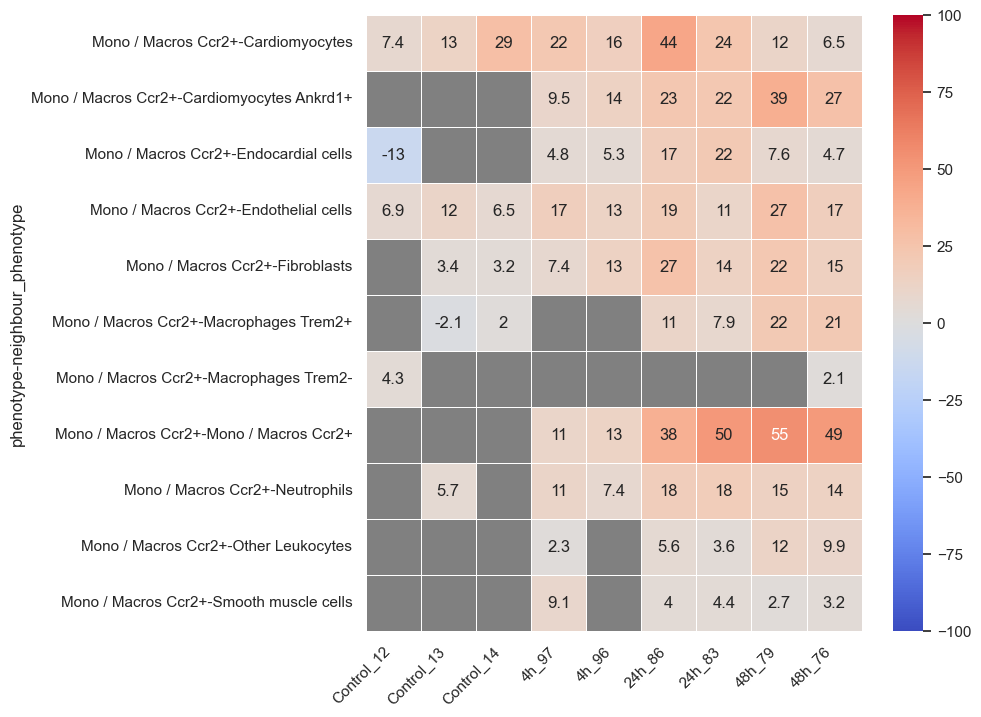

In [48]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05


# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Mono / Macros Ccr2+']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
#df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -100 # set based on your dataset's minimum z-score
vmax = 100   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_96956/3092578524.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



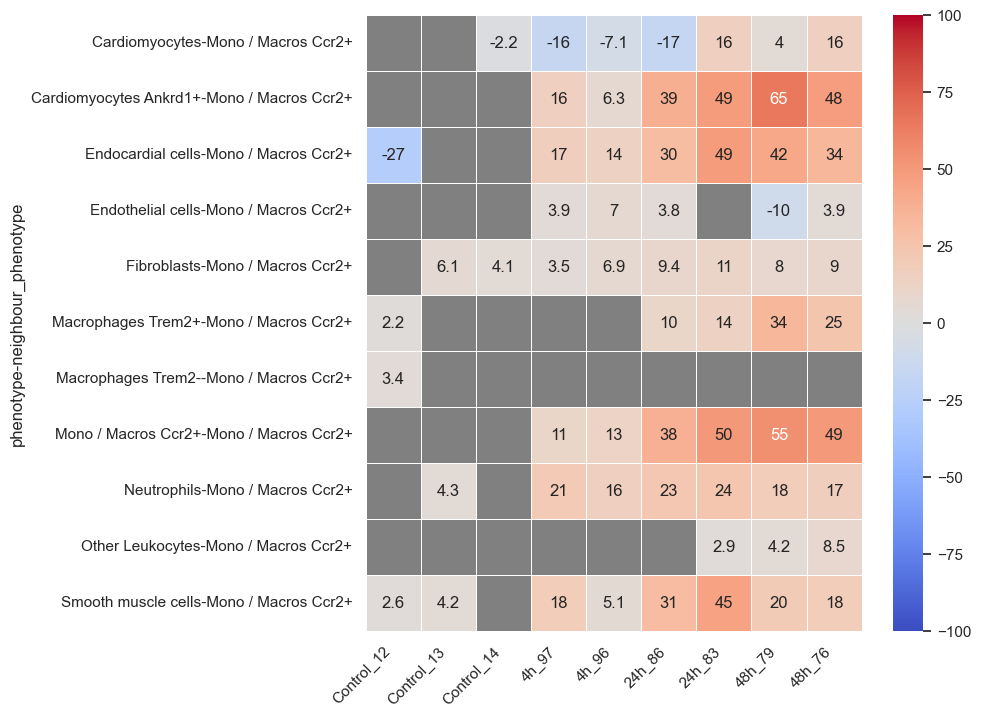

In [47]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05


# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Mono / Macros Ccr2+']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
#df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df[df['neighbour_phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -100 # set based on your dataset's minimum z-score
vmax = 100   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, annot = True)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
#plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_mon_endocard_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


# All

In [22]:
spatial.uns['dirSEA_knn10']

phenotype     neighbour_phenotype    24h_86  pvalue_24h_86  \
0         Cardiomyocytes          Cardiomyocytes  1.000000   0.000000e+00   
1         Cardiomyocytes  Cardiomyocytes Ankrd1+ -0.066589   0.000000e+00   
2         Cardiomyocytes       Endocardial cells -0.008270   2.856604e-81   
3         Cardiomyocytes       Endothelial cells  0.178661  2.802964e-189   
4         Cardiomyocytes             Fibroblasts  0.084973   6.604431e-01   
..                   ...                     ...       ...            ...   
116  Smooth muscle cells      Macrophages Trem2- -0.004570   2.003223e-01   
117  Smooth muscle cells     Mono / Macros Ccr2+  0.104341   7.129119e-01   
118  Smooth muscle cells             Neutrophils -0.044935   4.574857e-09   
119  Smooth muscle cells        Other Leukocytes -0.000762   6.730189e-02   
120  Smooth muscle cells     Smooth muscle cells  1.000000   0.000000e+00   

       24h_83  pvalue_24h_83  Control_13  pvalue_Control_13  Control_12  \
0    1.000000   0.000000e+00   -1.000000       2.014753e-18    1.000000   
1   -0.065299   0.000000e+00   -0.001635       6.025504e-06   -0.016132   
2   -0.012654   8.565567e-32   -0.008018       3.114916e-70   -0.006901   
3    0.379684   0.000000e+00    0.505469      7.999744e-285   -0.270595   
4    0.148828   1.894563e-77   -0.157739       6.372851e-60   -0.050526   
..        ...            ...         ...                ...         ...   
116 -0.000000   2.333873e-02   -0.000000       4.738141e-03    0.001957   
117 -0.208333   9.811316e-04   -0.003490       2.484777e-01    0.021526   
118 -0.073446   1.123903e-08   -0.000000       4.598579e-01   -0.000000   
119 -0.006356   5.053985e-01   -0.001745       3.676844e-01    0.001957   
120  1.000000   0.000000e+00    0.696335       0.000000e+00    0.589041   

     pvalue_Control_12     4h_97  pvalue_4h_97     4h_96  pvalue_4h_96  \
0        5.565155e-238  1.000000  0.000000e+00  1.000000  0.000000e+00   
1        9.211699e-123 -0.072374  0.000000e+00 -0.183329  0.000000e+00   
2         5.523953e-82 -0.006775  6.563640e-39 -0.008465  1.926965e-06   
3         1.639459e-06  0.201676  5.688804e-29  0.163552  3.055001e-67   
4        5.398533e-159 -0.083143  2.221812e-29 -0.069674  5.258037e-02   
..                 ...       ...           ...       ...           ...   
116       4.651974e-03 -0.004834  6.656990e-01 -0.000000  1.356256e-01   
117       1.942611e-02  0.034441  8.503286e-01  0.030011  5.550436e-03   
118       3.232166e-01 -0.028399  1.395132e-14 -0.008574  8.725142e-05   
119       8.806272e-01  0.007855  6.333635e-01  0.012862  3.862369e-01   
120       0.000000e+00  1.000000  0.000000e+00  1.000000  0.000000e+00   

       48h_79  pvalue_48h_79    48h_76  pvalue_48h_76  Control_14  \
0    1.000000   0.000000e+00  1.000000   0.000000e+00    1.000000   
1   -0.034553   0.000000e+00 -0.039060   0.000000e+00   -0.000485   
2   -0.013573   2.539129e-08  0.024675   4.331407e-10   -0.004861   
3    0.796062   0.000000e+00  0.361140   0.000000e+00   -0.096038   
4    0.300578   4.305995e-06  0.157650   7.847924e-01   -0.047525   
..        ...            ...       ...            ...         ...   
116 -0.003336   7.695915e-01 -0.002710   8.022287e-02   -0.005919   
117 -0.131776   2.379814e-23 -0.228997   1.521998e-17    0.002492   
118 -0.023353   7.055073e-08 -0.075881   5.490418e-06   -0.000000   
119 -0.031693   6.456757e-01  0.042005   7.195314e-01    0.000935   
120  1.000000   0.000000e+00  1.000000   0.000000e+00    0.658567   

     pvalue_Control_14  
0         0.000000e+00  
1         2.423709e-12  
2        4.086882e-250  
3         1.734791e-86  
4        9.660796e-271  
..                 ...  
116       1.535036e-01  
117       7.333460e-01  
118       3.011262e-01  
119       1.178710e-01  
120       0.000000e+00  

[121 rows x 20 columns]

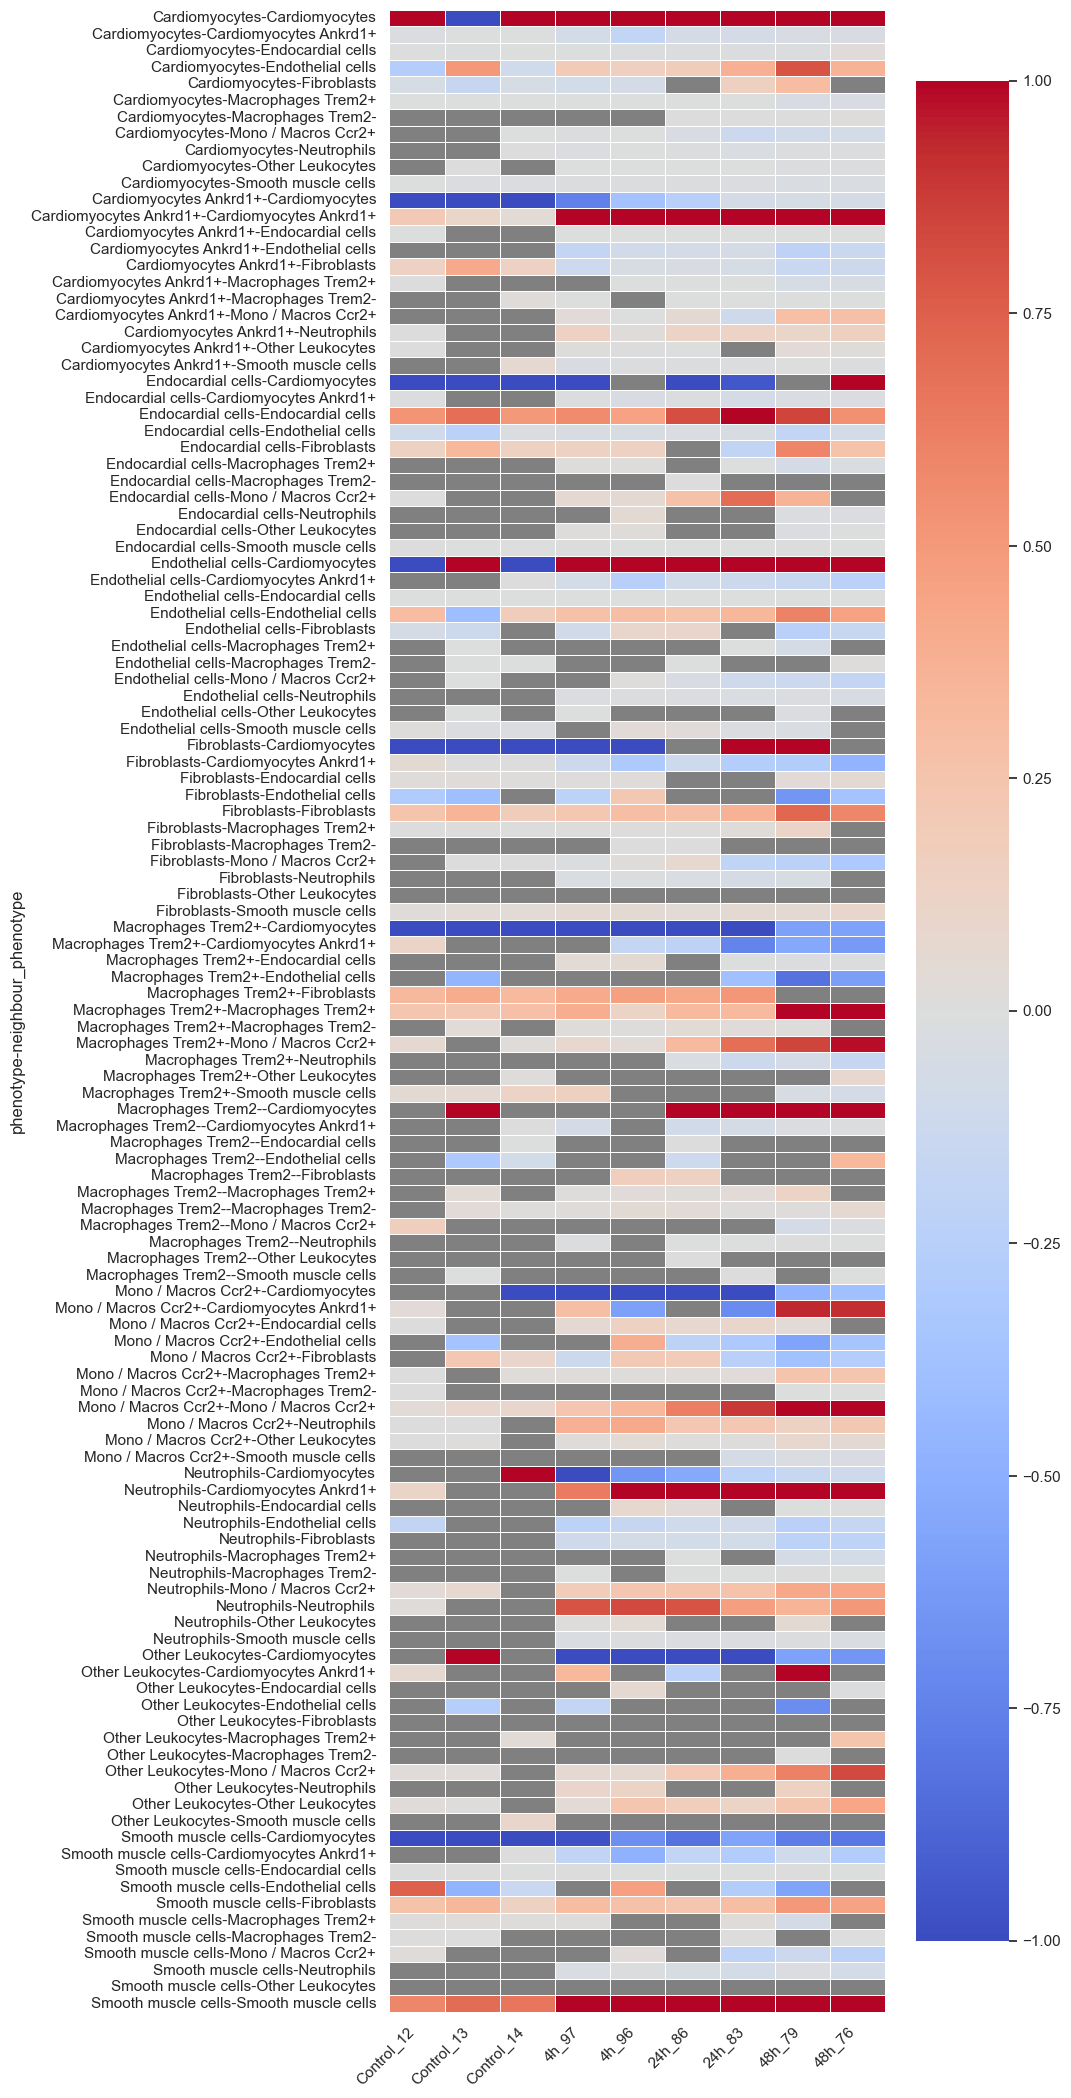

In [25]:
# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
#df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05

# reorder samples on the heatmap x axis accordingly
# column_order = [
#                 'zscore_Control_12',
#                 'zscore_Control_13',
#                 'zscore_Control_14',
#                 'zscore_4h_97',
#                 'zscore_4h_96',
#                 'zscore_24h_86',
#                 'zscore_24h_83',
#                 'zscore_48h_79',
#                 'zscore_48h_76']

# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
#phenotypes_to_include = ['Endocardial cells']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
#df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
#df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]
df_filtered = df

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
# for col in df.columns:
#     if col.startswith('zscore'):
#         pval_col = col.replace('zscore', 'pvalue')
#         df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

for col in column_order:
    # Find the corresponding p-value column
    pval_col = f"pvalue_{col}"
    
    # Check if the p-value column exists
    if pval_col in df.columns:
        # Apply the filter: Keep values in `col` only if the p-value is below the threshold
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
#heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype'])#
#reorder columns
heatmap_data = heatmap_data[column_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -1 # set based on your dataset's minimum z-score
vmax = 1   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(8, 26))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_allcells_heatmap_scimap.svg", format='svg', bbox_inches='tight')
plt.show()


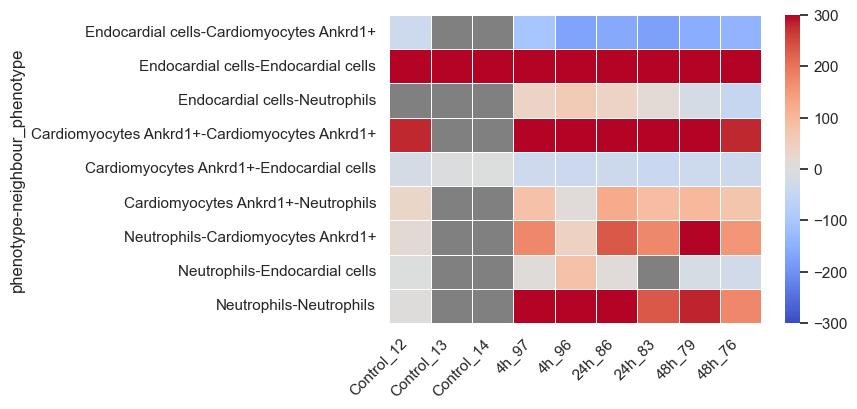

In [132]:

# Define data and parameters
df = spatial.uns['dirSEA_knn10']
# Switching the column names to have directionality the right way around (will adapt in method)
df = df.rename(columns={'phenotype': 'neighbour_phenotype', 'neighbour_phenotype': 'phenotype'})
pval_threshold = 0.05

# reorder samples on the heatmap x axis accordingly
column_order = [
                'zscore_Control_12', 
                'zscore_Control_13',
                'zscore_Control_14',
                'zscore_4h_97', 
                'zscore_4h_96', 
                'zscore_24h_86', 
                'zscore_24h_83', 
                'zscore_48h_79', 
                'zscore_48h_76'] 

row_order = ['Endocardial cells', 'Cardiomyocytes Ankrd1+', 'Neutrophils'] 

# Example list of phenotypes you want to include in the heatmap
#phenotypes_to_include = ['Mono / Macros Ccr2+', 'Endocardial cells', 'Cardiomyocytes', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
phenotypes_to_include = ['Endocardial cells', 'Cardiomyocytes Ankrd1+', 'Neutrophils']  # Update this list with your specific phenotypes
# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]
df_filtered = df_filtered[df_filtered['neighbour_phenotype'].isin(phenotypes_to_include)]

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

        # Sort the DataFrame by phenotype and neighbour phenotype alphabetically
df_filtered = df_filtered.sort_values(by=['phenotype', 'neighbour_phenotype'])


# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
#reorder columns
heatmap_data = heatmap_data[column_order]
heatmap_data = heatmap_data.loc[row_order]
# Remove 'score_' from all column names
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Create a mask for NA values
mask = heatmap_data.isna()  # Create a mask for NA values

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray


# Set the min and max z-scores in the filtered data
vmin = -300 # set based on your dataset's minimum z-score
vmax = 300   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask)
#plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Save the plot as SVG
plt.savefig("./../../SCNA_thesis/Paper_figures/dirSEA_v2/MI_neutrophils_cardiomyocytes_heatmap_dirSEA.svg", format='svg', bbox_inches='tight')
plt.show()


/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_1965/1712896081.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



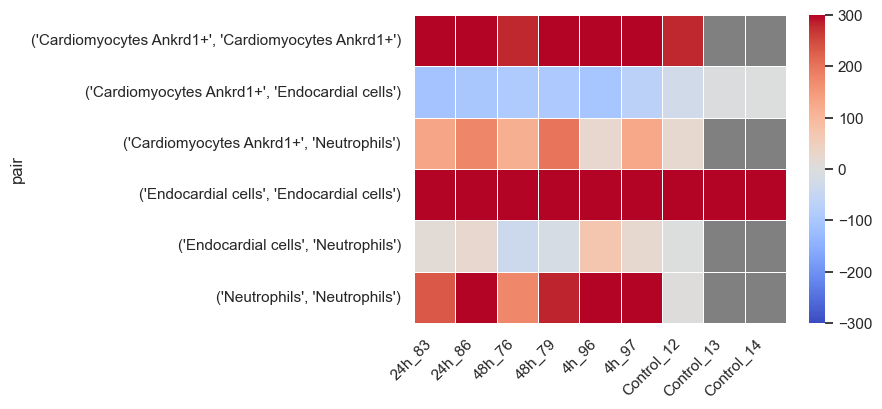

In [129]:
#try to reorder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Create a new column to ensure similar interactions are next to each other
df['pair'] = df.apply(lambda x: tuple(sorted([x['phenotype'], x['neighbour_phenotype']])), axis=1)

# Filter and sort
phenotypes_to_include = ['Endocardial cells', 'Cardiomyocytes Ankrd1+', 'Neutrophils']
df_filtered = df[df['phenotype'].isin(phenotypes_to_include) & df['neighbour_phenotype'].isin(phenotypes_to_include)]

# Optionally filter based on p-values
pval_threshold = 0.05
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df_filtered[col] = np.where(df_filtered[pval_col] <= pval_threshold, df_filtered[col], np.nan)

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.pivot_table(index='pair', values=df_filtered.filter(like='zscore').columns, aggfunc='mean')

# Remove 'score_' from all column names (if necessary)
heatmap_data.columns = heatmap_data.columns.str.replace('zscore_', '')

# Reorder based on the alphabetical order of the phenotype pairs
heatmap_data.sort_index(inplace=True)

# Create a mask for NA values
mask = heatmap_data.isna()

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='gray')  # Set the color for NA values to gray

# Set the min and max z-scores in the filtered data
vmin = -300  # set based on your dataset's minimum z-score
vmax = 300   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, linewidths=.5, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


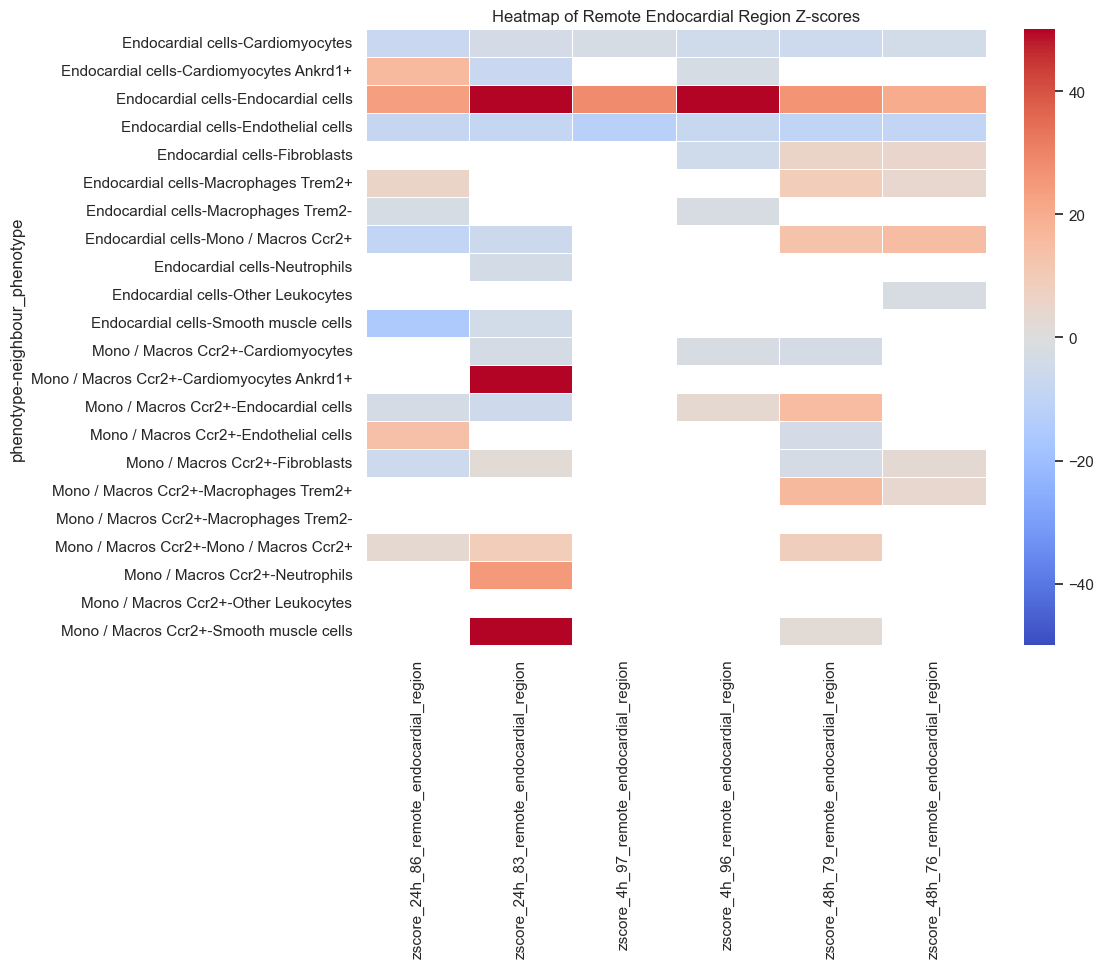

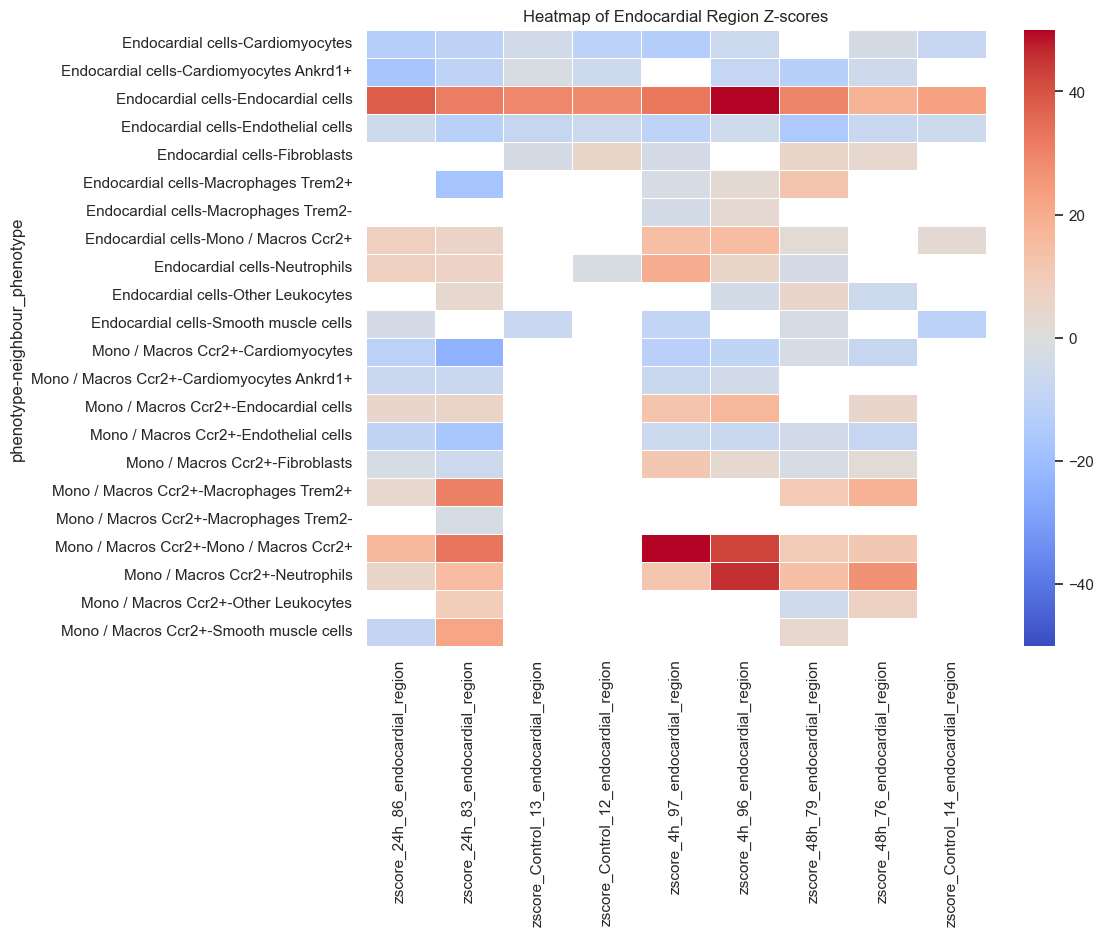

In [149]:
# split the plot by region

# Set a p-value threshold for significance
pval_threshold = 0.05

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df[col] = np.where(df[pval_col] <= pval_threshold, df[col], np.nan)

# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]

# Split the DataFrame based on the presence of 'remote_endocardial_region' and 'endocardial_region' in the column names
remote_columns = [col for col in df_filtered.columns if 'remote_endocardial_region' in col]
endocardial_columns = [col for col in df_filtered.columns if 'endocardial_region' in col and 'remote' not in col]

# Split the data into two DataFrames
df_remote = df_filtered[['phenotype', 'neighbour_phenotype'] + remote_columns]
df_endocardial = df_filtered[['phenotype', 'neighbour_phenotype'] + endocardial_columns]

# Pivot the data for heatmap-friendly format
heatmap_data_remote = df_remote.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
heatmap_data_endocardial = df_endocardial.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')

# Determine the min and max z-scores in the filtered data (adjust these as needed)
vmin = -50  # Based on your dataset's minimum z-score
vmax = 50   # Based on your dataset's maximum z-score

# Plot heatmap for remote_endocardial_region
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_remote, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax)
plt.title('Heatmap of Remote Endocardial Region Z-scores')
plt.show()

# Plot heatmap for endocardial_region (excluding remote)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_endocardial, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax)
plt.title('Heatmap of Endocardial Region Z-scores')
plt.show()


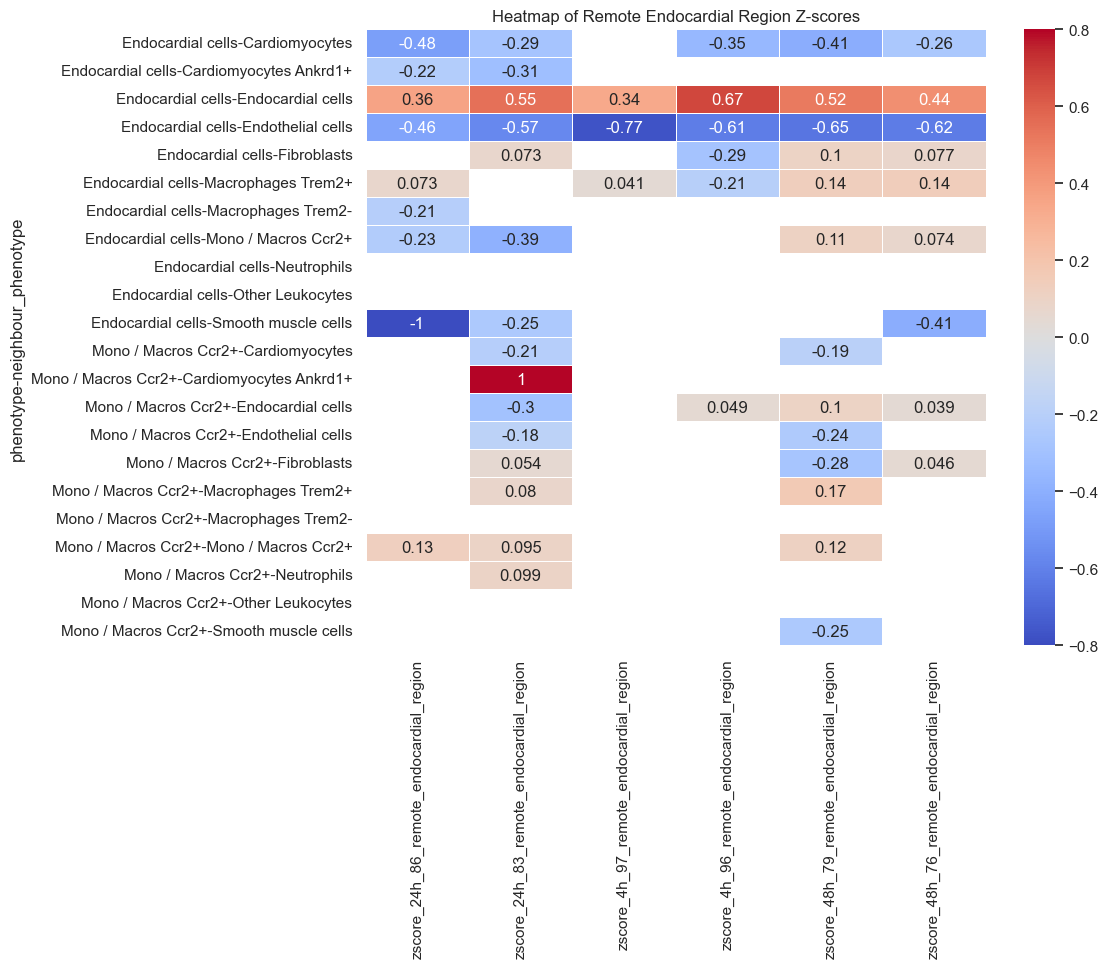

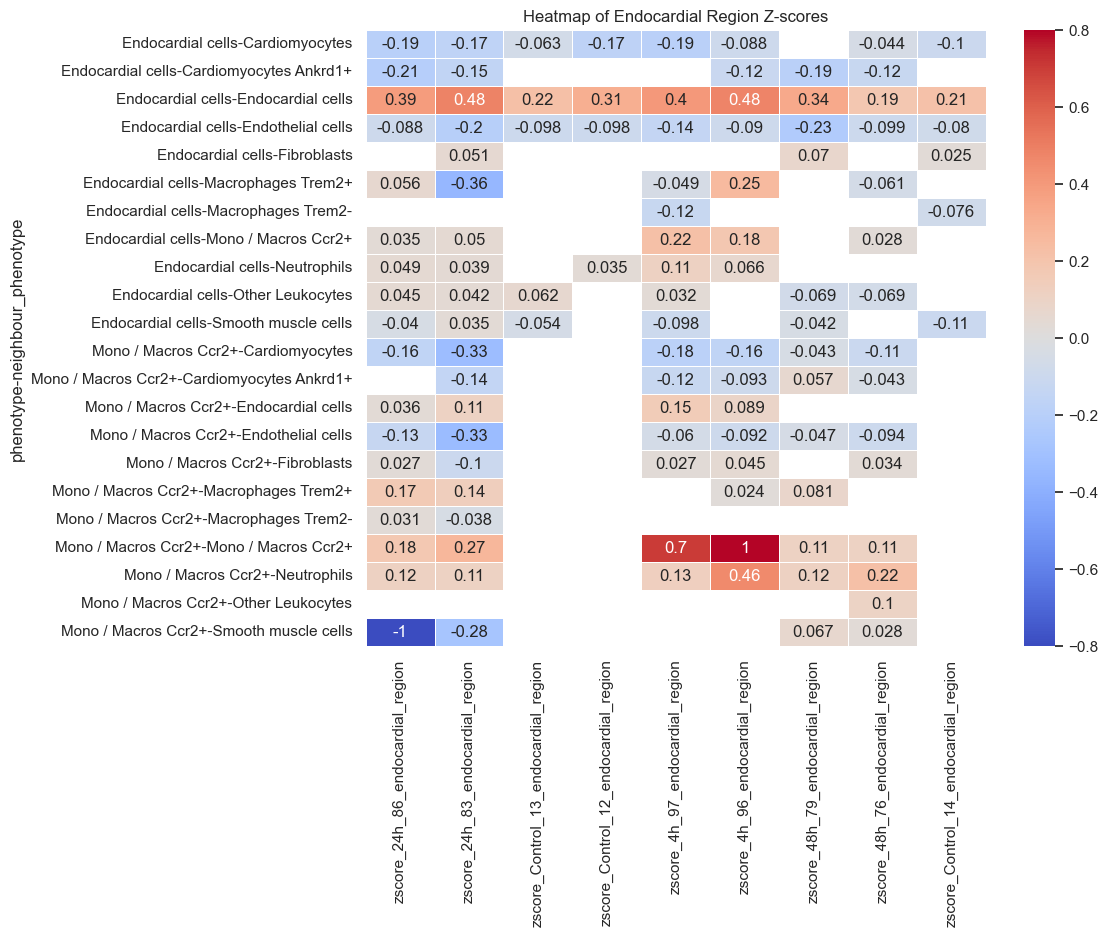

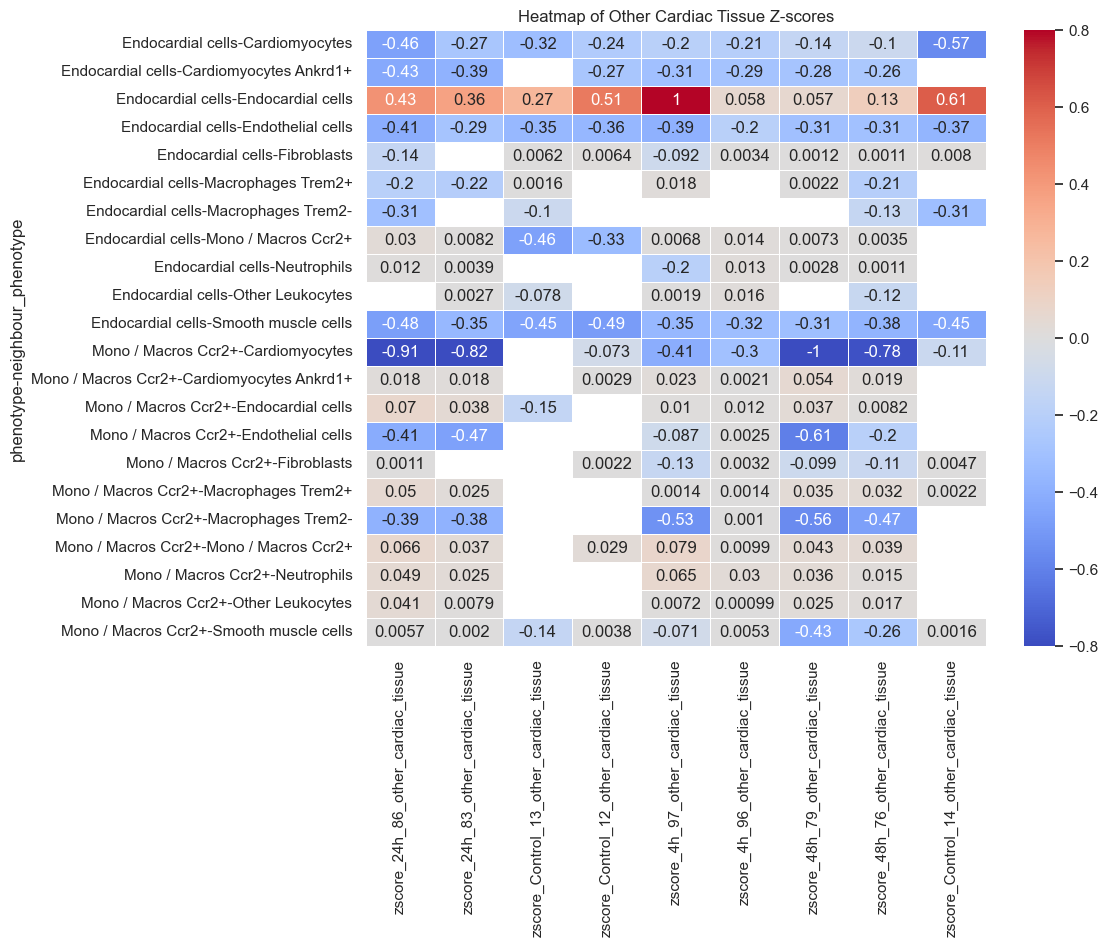

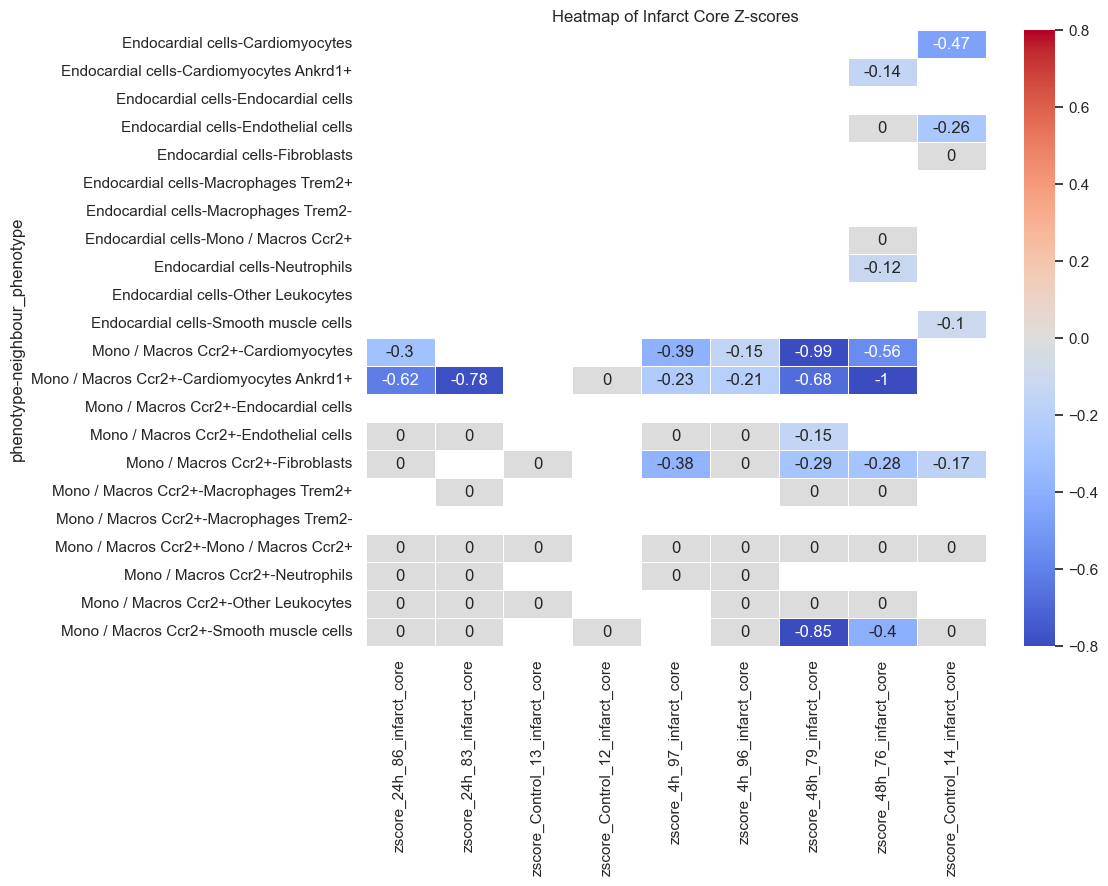

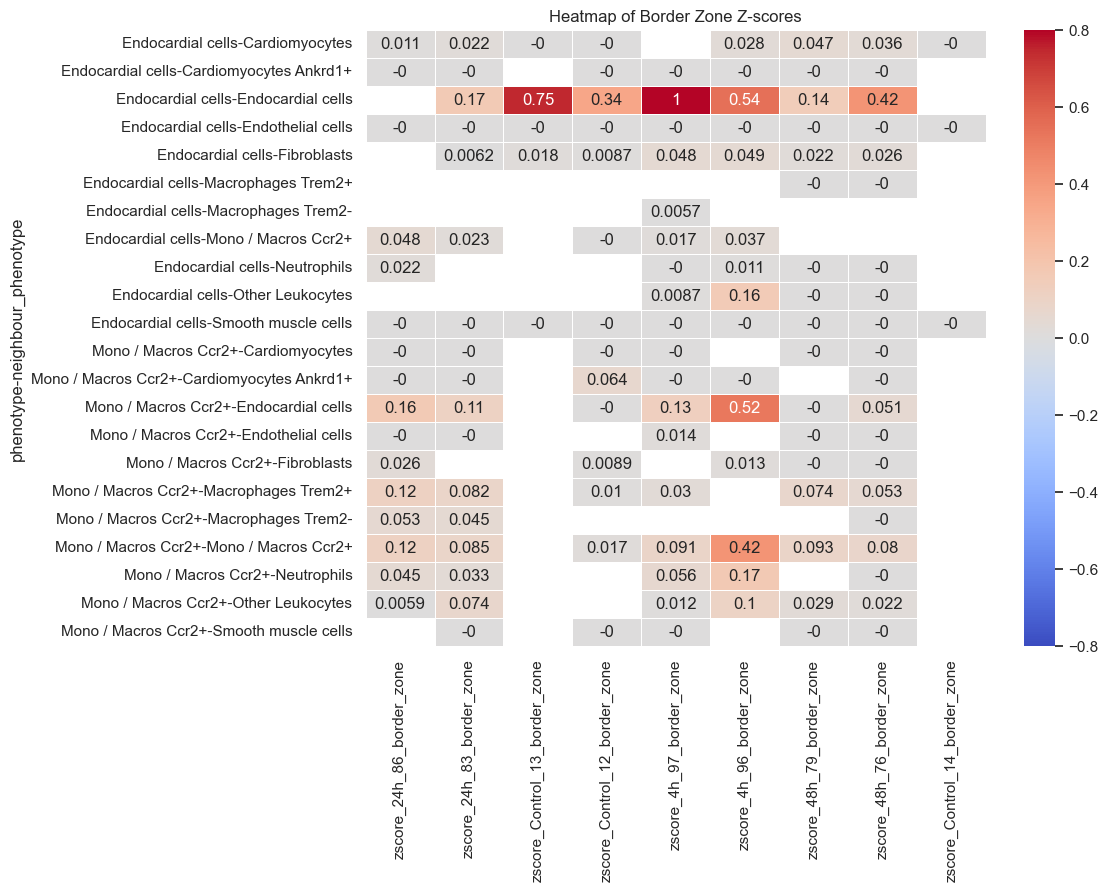

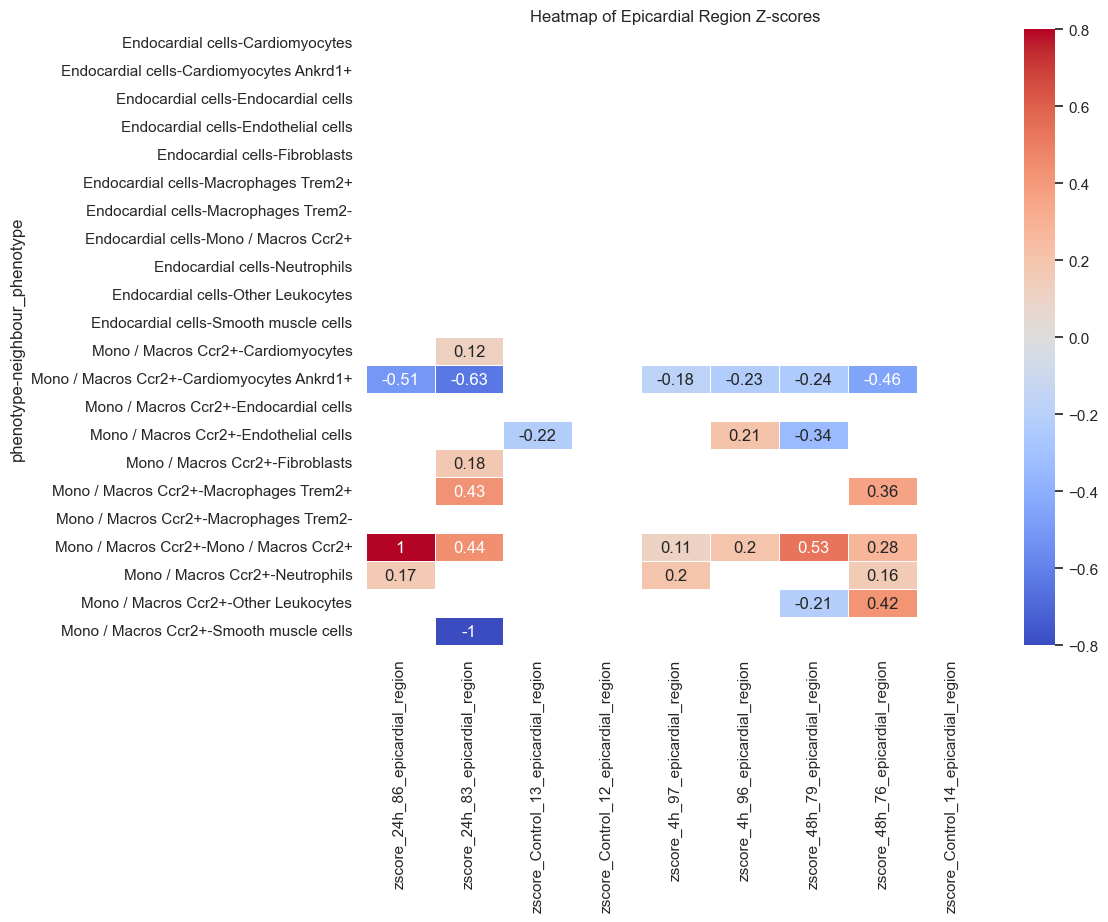

In [174]:
#split my all regions

# Set a p-value threshold for significance
# Set a p-value threshold for significance
pval_threshold = 0.01

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df[col] = np.where(df[pval_col] <= pval_threshold, df[col], np.nan)

# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]

# Define a list of regions to create separate heatmaps for
regions_of_interest = [
    'remote_endocardial_region',         # Include endocardial_region
    'endocardial_region',  # Include remote_endocardial_region
    'other_cardiac_tissue',
    'infarct_core',
    'border_zone',
    'epicardial_region'
]

# Determine the min and max z-scores in the filtered data (adjust these as needed)
vmin = -0.8  # Based on your dataset's minimum z-score
vmax = 0.8  # Based on your dataset's maximum z-score

# Iterate over each region and plot heatmap
for region in regions_of_interest:
    # Get the columns for the current region
    region_columns = [col for col in df_filtered.columns if region in col]
    if region == "endocardial_region":
        region_columns = [col for col in df_filtered.columns if region in col and 'remote' not in col]
    
    if region_columns:  # Check if there are columns for the current region
        # Create a DataFrame for the current region
        df_region = df_filtered[['phenotype', 'neighbour_phenotype'] + region_columns]
        
        # Pivot the dataframe to get a heatmap-friendly format
        heatmap_data_region = df_region.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')
        
        # Custom scaling to keep 0 as 0 and scale according to max positive value
        max_positive = heatmap_data_region[heatmap_data_region > 0].max().max()
        min_negative = heatmap_data_region.min().min()
        
        # Scale the values
        scaled_data = heatmap_data_region.copy()
        scaled_data[scaled_data > 0] = scaled_data[scaled_data > 0] / max_positive
        scaled_data[scaled_data < 0] = scaled_data[scaled_data < 0] / abs(min_negative)

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(scaled_data, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax, annot=True)
        plt.title(f'Heatmap of {region.replace("_", " ").title()} Z-scores')
        plt.show()

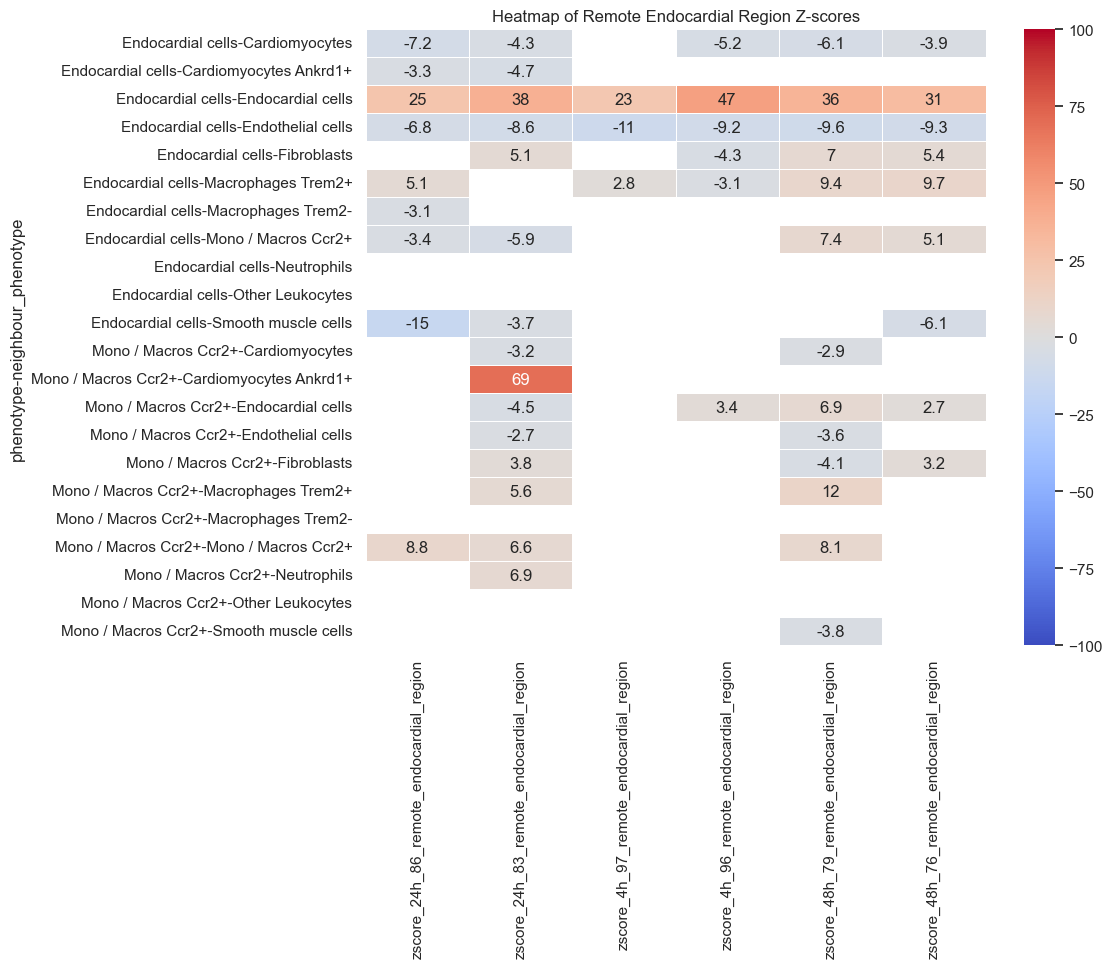

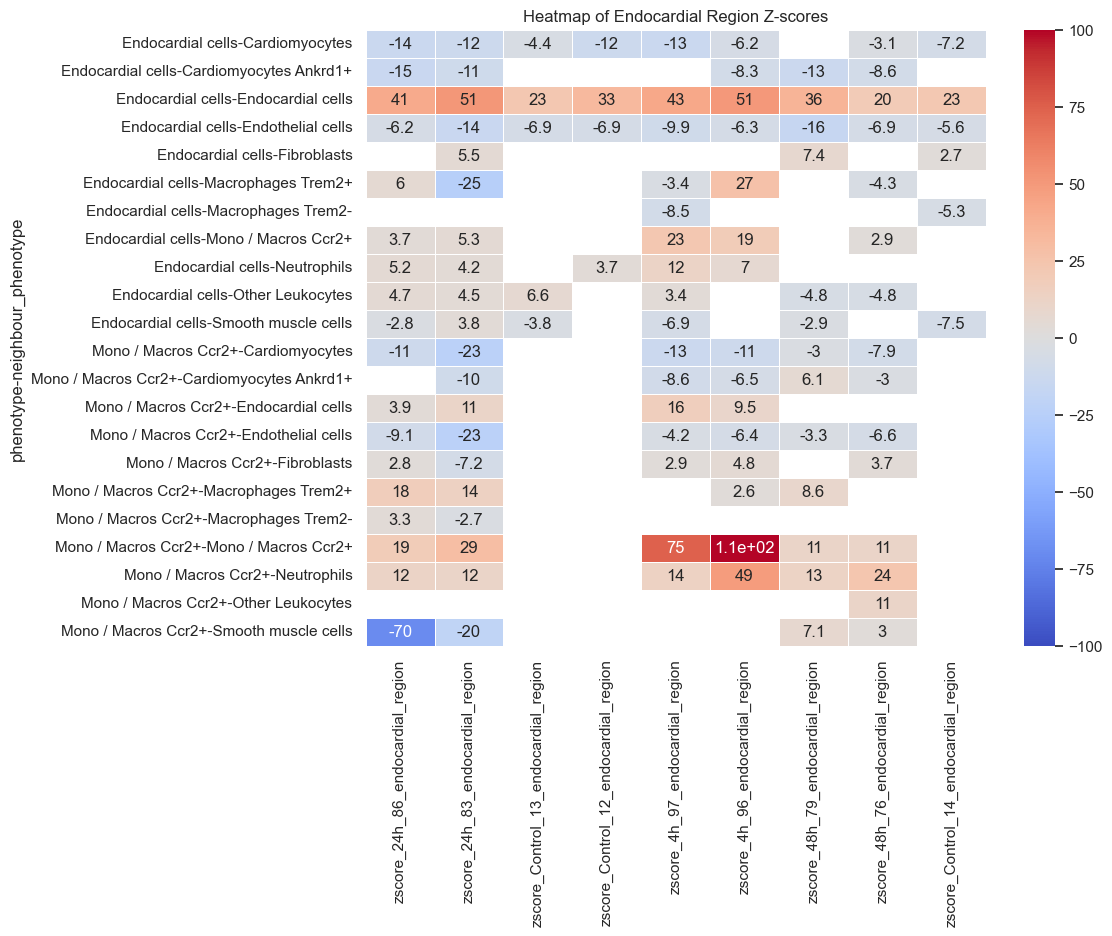

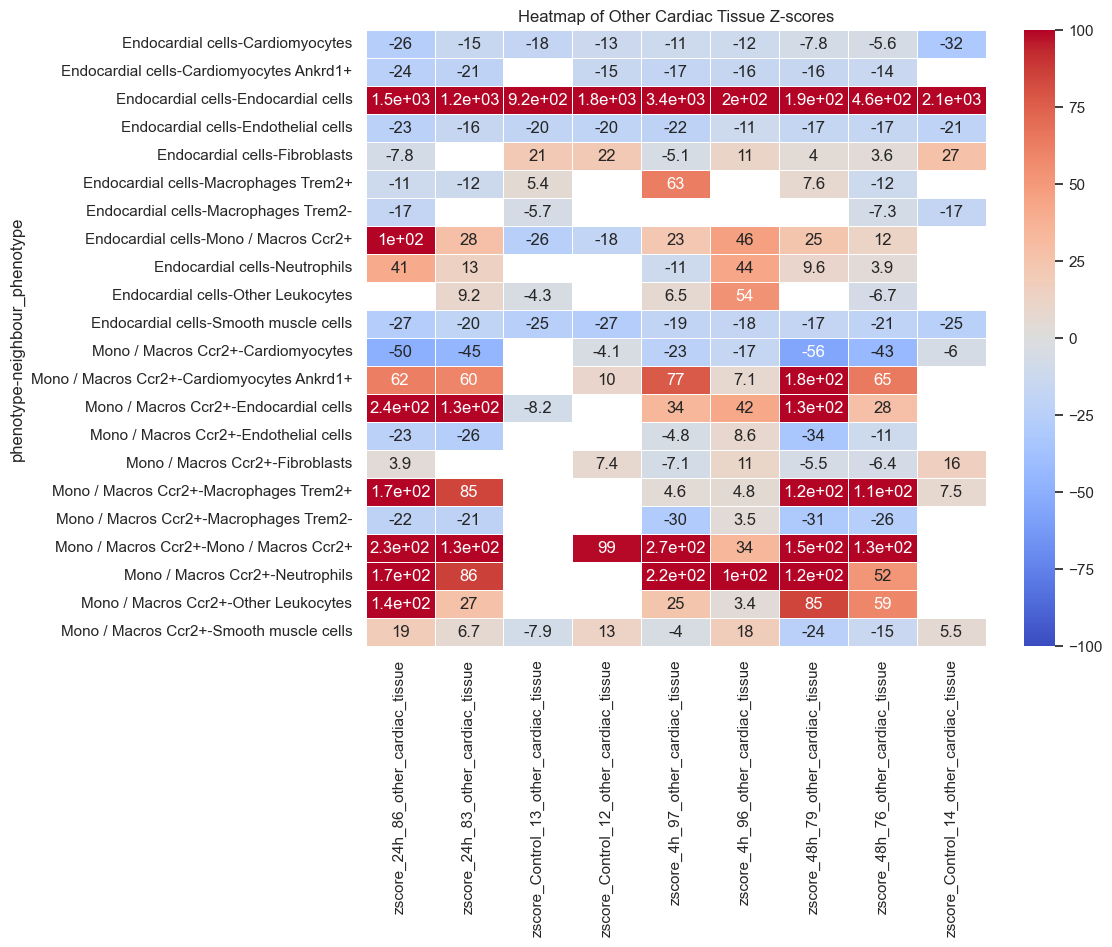

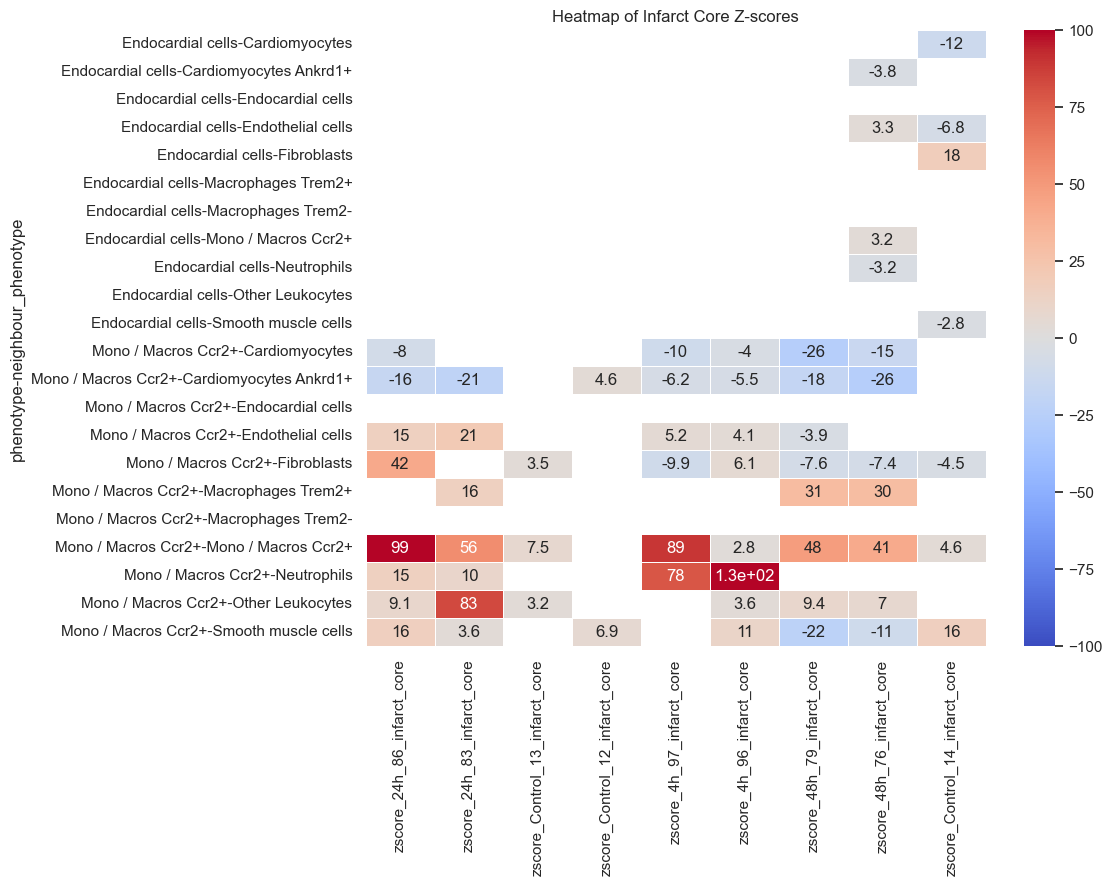

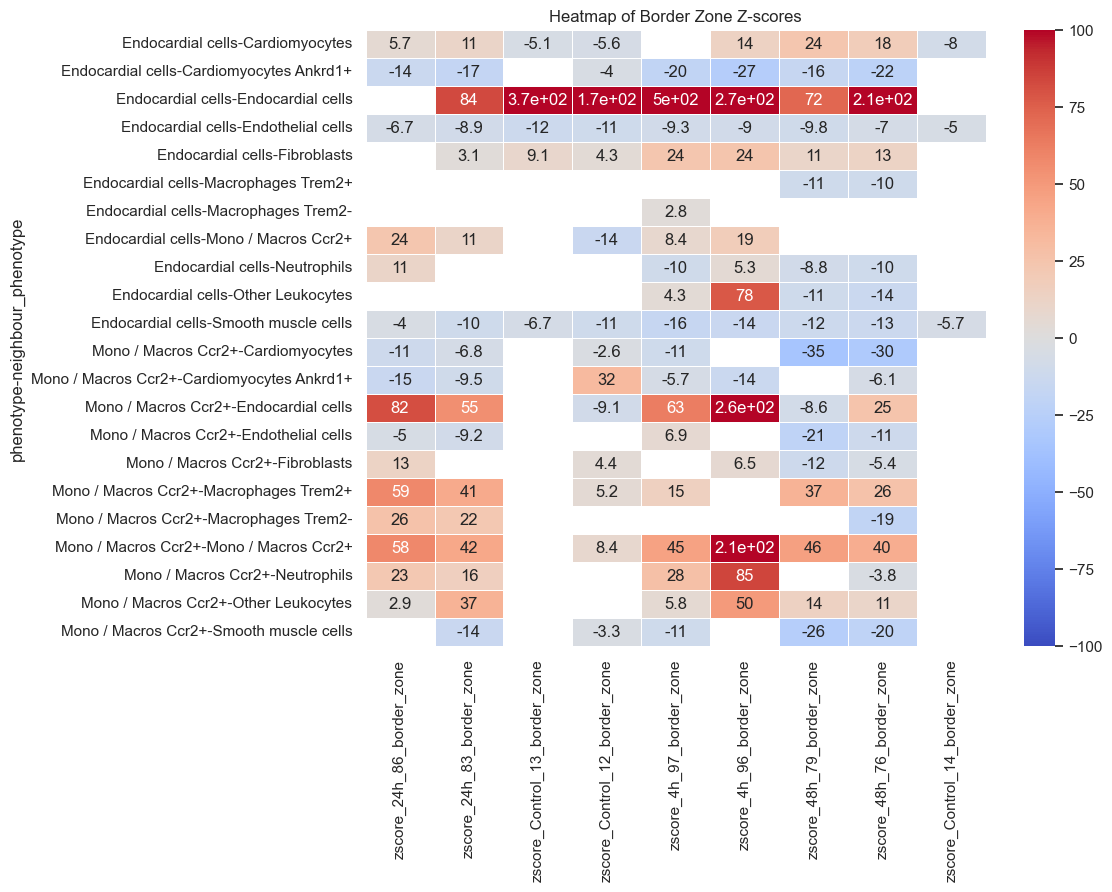

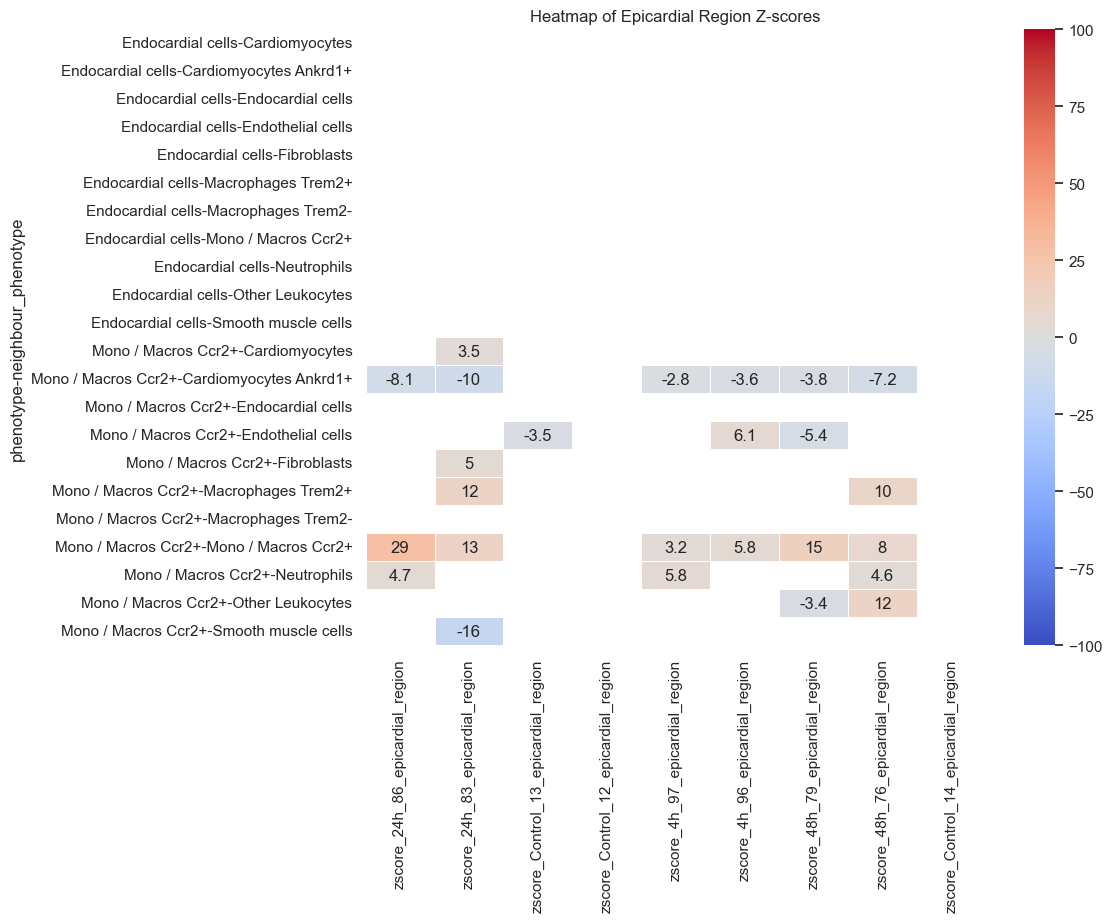

In [175]:
#split my all regions NOT SCALED

# Set a p-value threshold for significance
# Set a p-value threshold for significance
pval_threshold = 0.01

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes

# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df[col] = np.where(df[pval_col] <= pval_threshold, df[col], np.nan)

# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]

# Define a list of regions to create separate heatmaps for
regions_of_interest = [
    'remote_endocardial_region',         # Include endocardial_region
    'endocardial_region',  # Include remote_endocardial_region
    'other_cardiac_tissue',
    'infarct_core',
    'border_zone',
    'epicardial_region'
]

# Determine the min and max z-scores in the filtered data (adjust these as needed)
vmin = -100  # Based on your dataset's minimum z-score
vmax = 100  # Based on your dataset's maximum z-score

# Iterate over each region and plot heatmap
for region in regions_of_interest:
    # Get the columns for the current region
    region_columns = [col for col in df_filtered.columns if region in col]
    if region == "endocardial_region":
        region_columns = [col for col in df_filtered.columns if region in col and 'remote' not in col]
    
    if region_columns:  # Check if there are columns for the current region
        # Create a DataFrame for the current region
        df_region = df_filtered[['phenotype', 'neighbour_phenotype'] + region_columns]
        
        # Pivot the dataframe to get a heatmap-friendly format
        heatmap_data_region = df_region.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data_region, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax, annot=True)
        plt.title(f'Heatmap of {region.replace("_", " ").title()} Z-scores')
        plt.show()

In [130]:
# Extract unique region categories from the column names
#regions = set([col.split('_')[-1] for col in df.columns if 'zscore' in col])
regions = adata.obs['region_name'].unique()
regions


array(['other_cardiac_tissue', 'border_zone', 'remote_endocardial_region',
       'infarct_core', 'endocardial_region', 'epicardial_region'],
      dtype=object)

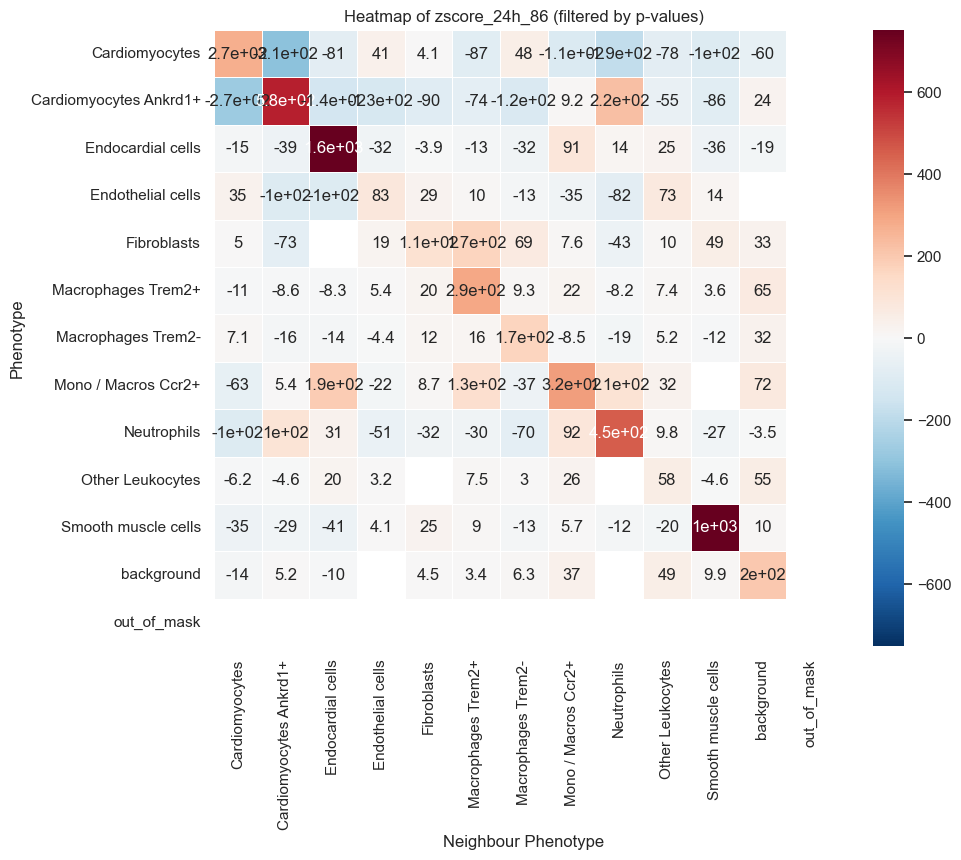

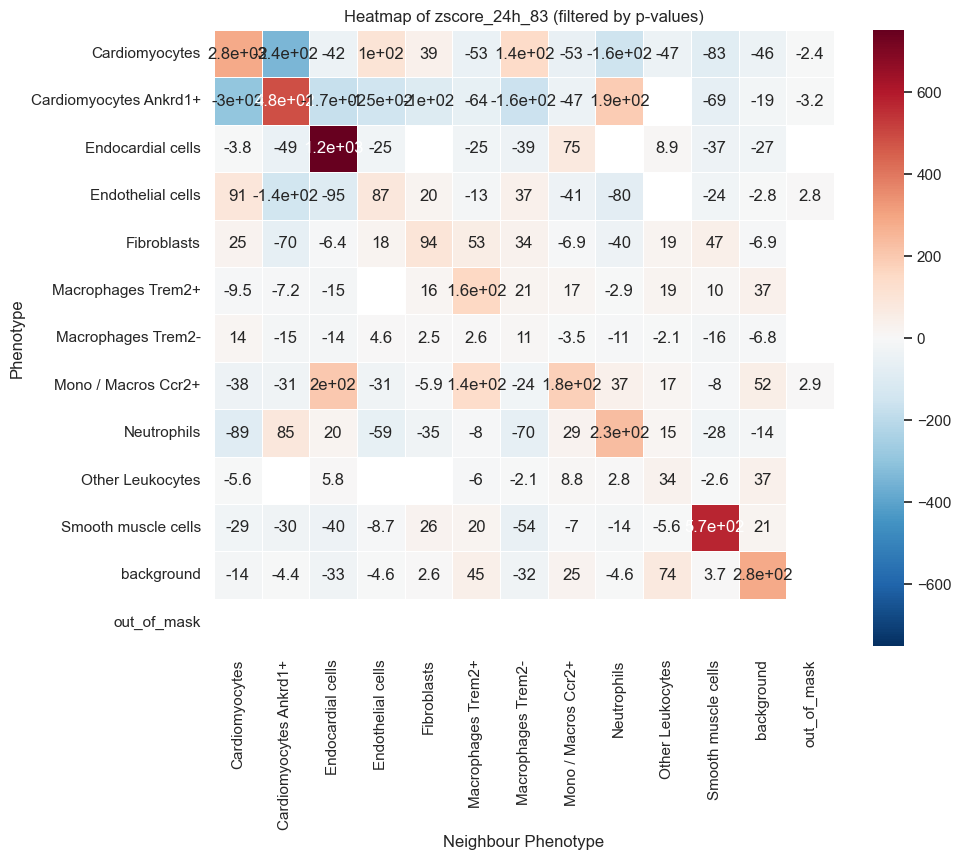

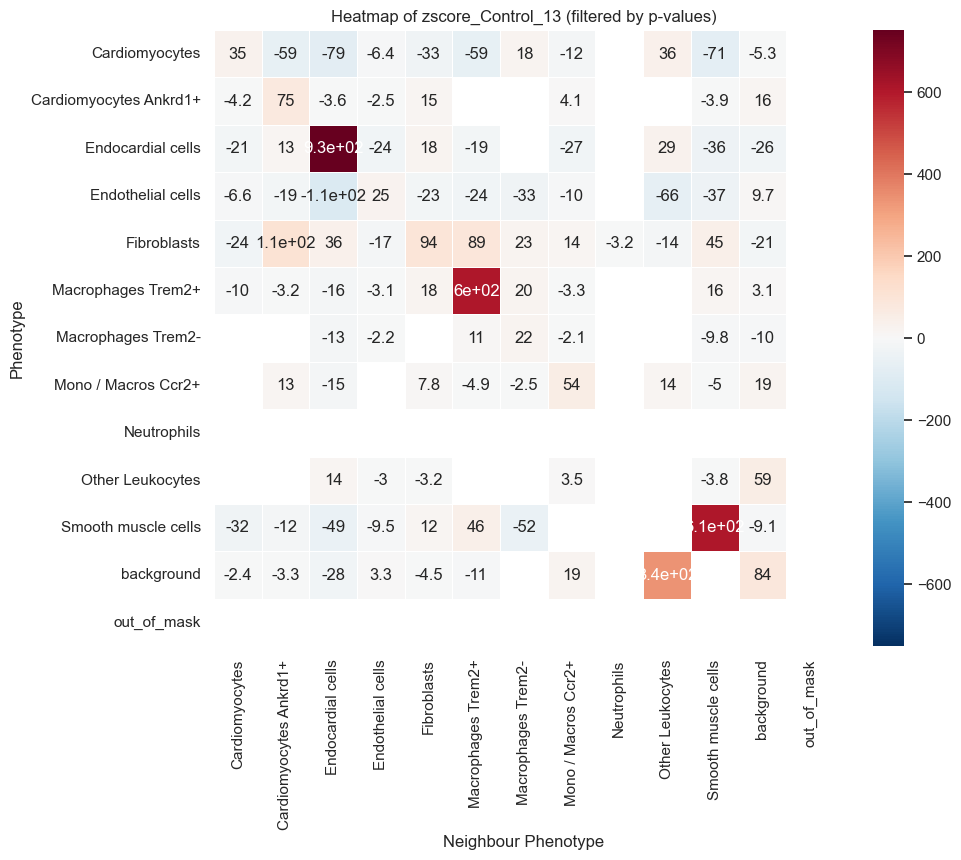

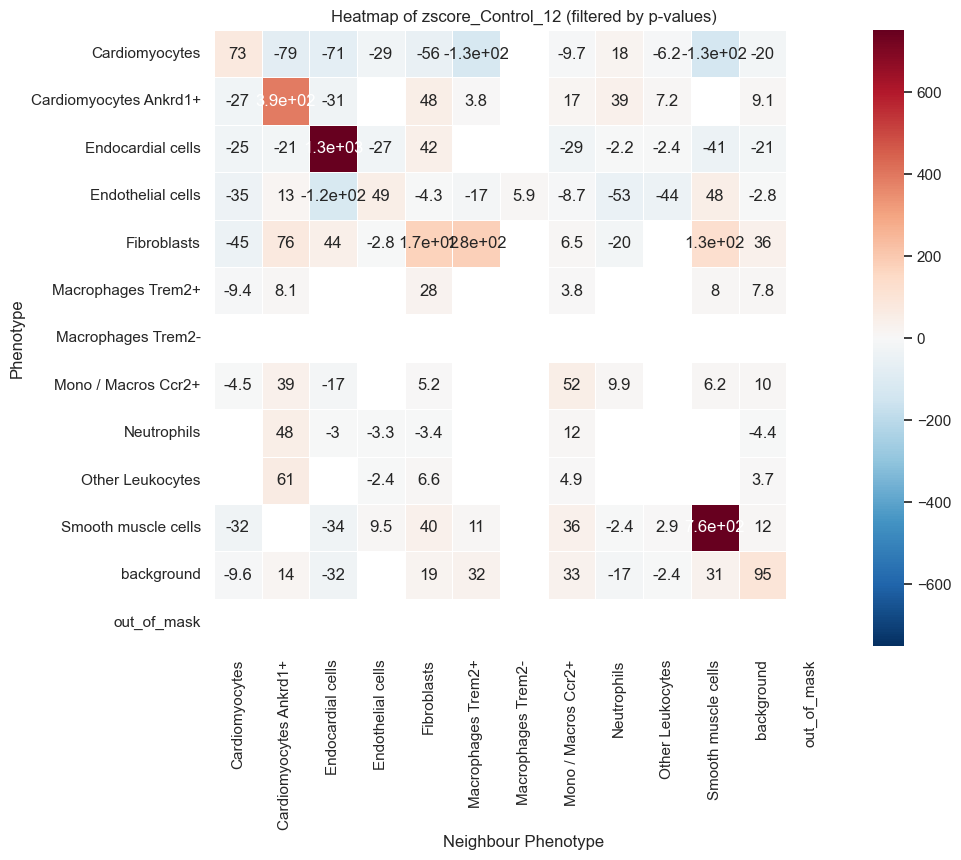

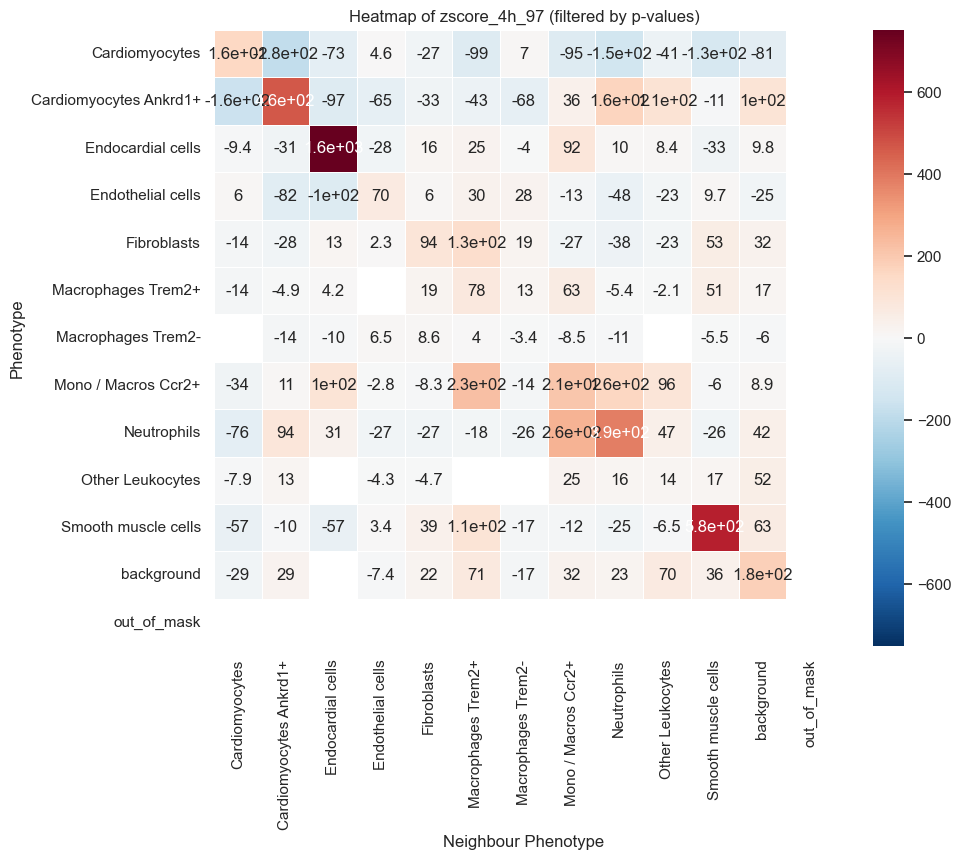

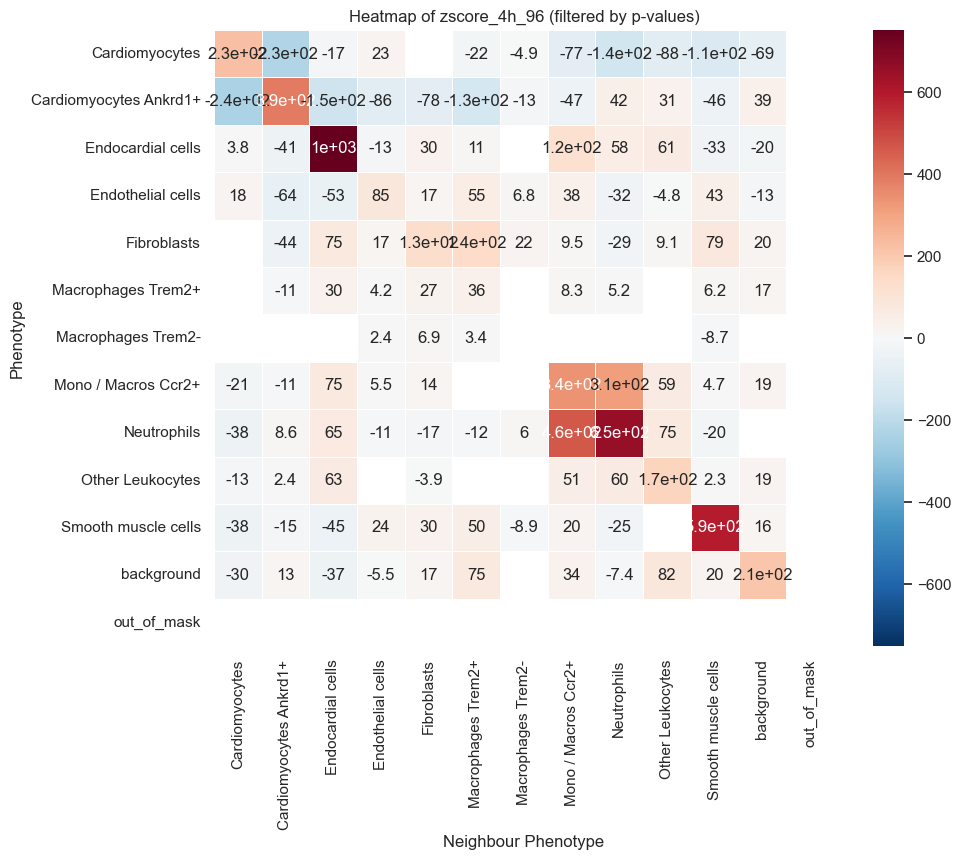

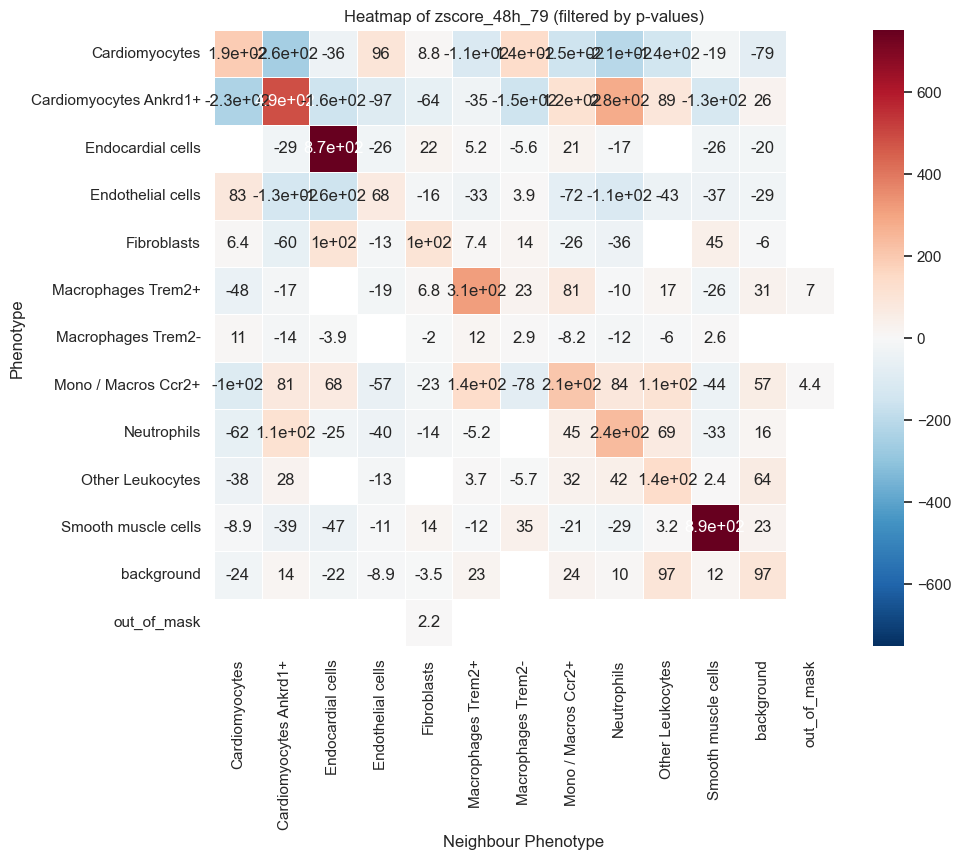

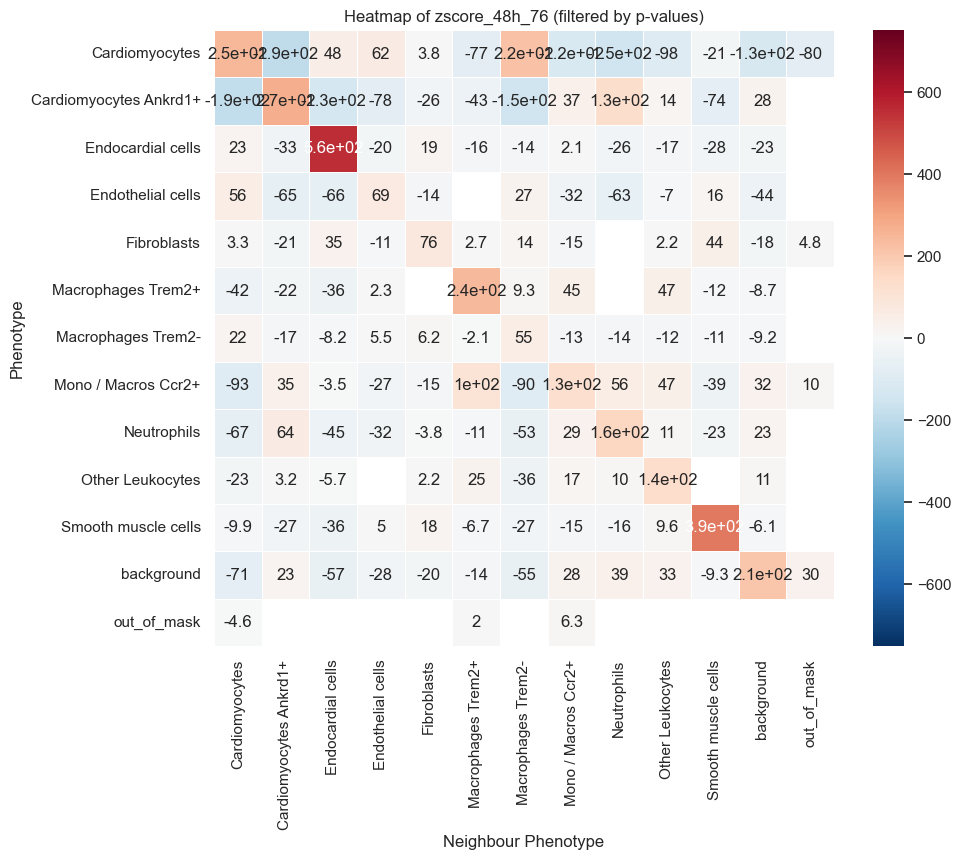

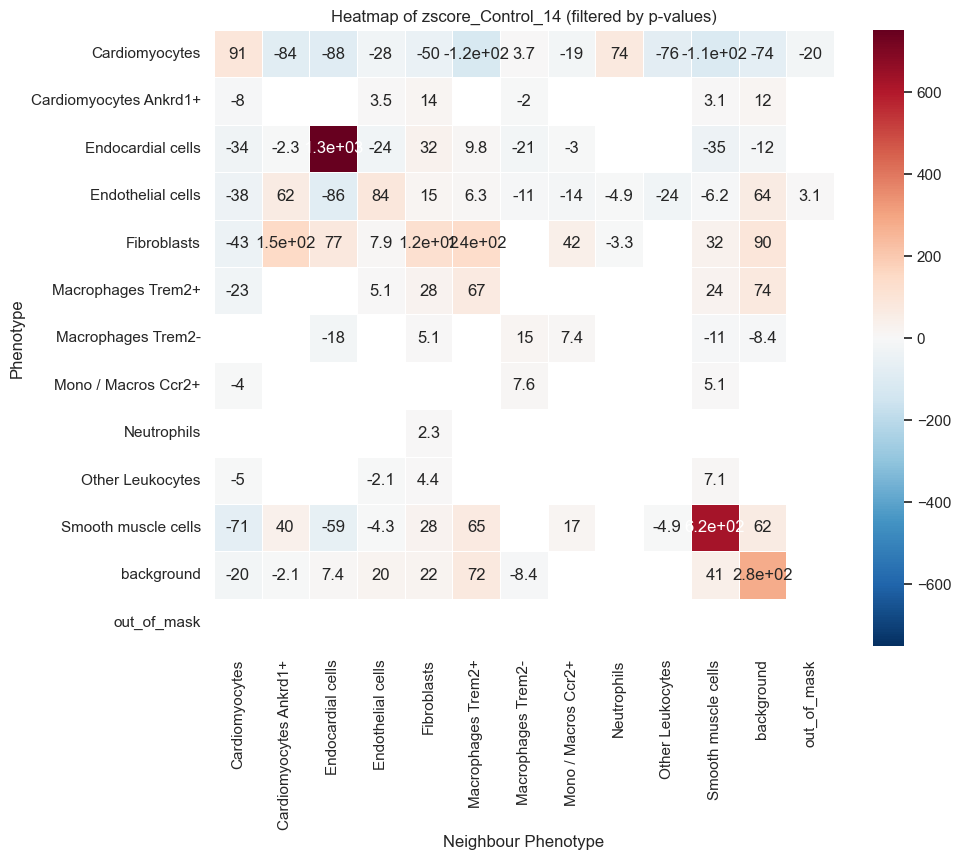

In [30]:
# one plot per sample

# List of z-score columns and corresponding sample names
zscore_columns = ['zscore_24h_86', 'zscore_24h_83', 'zscore_Control_13', 
                  'zscore_Control_12', 'zscore_4h_97', 'zscore_4h_96', 
                  'zscore_48h_79', 'zscore_48h_76', 'zscore_Control_14']

vmin = -750 # set based on your dataset's minimum z-score
vmax = 750   # set based on your dataset's maximum z-score

# Loop through each z-score column to create individual heatmaps
for zscore_col in zscore_columns:
    # Prepare the heatmap data: pivot with phenotype as rows and neighbor phenotype as columns
    heatmap_data = df.pivot(index='phenotype', columns='neighbour_phenotype', values=zscore_col)

    # Determine the min and max z-scores for this column
    z_min = heatmap_data.min().min()
    z_max = heatmap_data.max().max()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap="RdBu_r", vmin=vmin, vmax=vmax,linewidths=.5)
    plt.title(f'Heatmap of {zscore_col} (filtered by p-values)')
    plt.xlabel('Neighbour Phenotype')
    plt.ylabel('Phenotype')
    
    # Show the plot for each sample
    plt.show()

In [38]:
# run with total cell count normalization
# run spatial interaction analysis
spatial = sm.tl.spatial_interaction (adata,
                         x_coordinate='X_centroid',
                         y_coordinate='Y_centroid',
                         phenotype='refined_cell_type',
                         method='knn', 
                         #radius=30, 
                         knn=10,
                         permutation=100,
                         imageid='fov',
                         subset=None,
                         pval_method='zscore',
                         normalization='total',
                         verbose=True,
                         label='dirSEA_knn10_total')

Processing Image: ['24h_86']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['24h_83']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Control_13']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Control_12']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results
Processing Image: ['4h_97']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results
Processing Image: ['4h_96']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results
Processing Image: ['48h_79']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results
Processing Image: ['48h_76']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results
Processing Image: ['Control_14']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 100 permutations


/Users/chiaraschiller/miniconda3/envs/scimap_v2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results


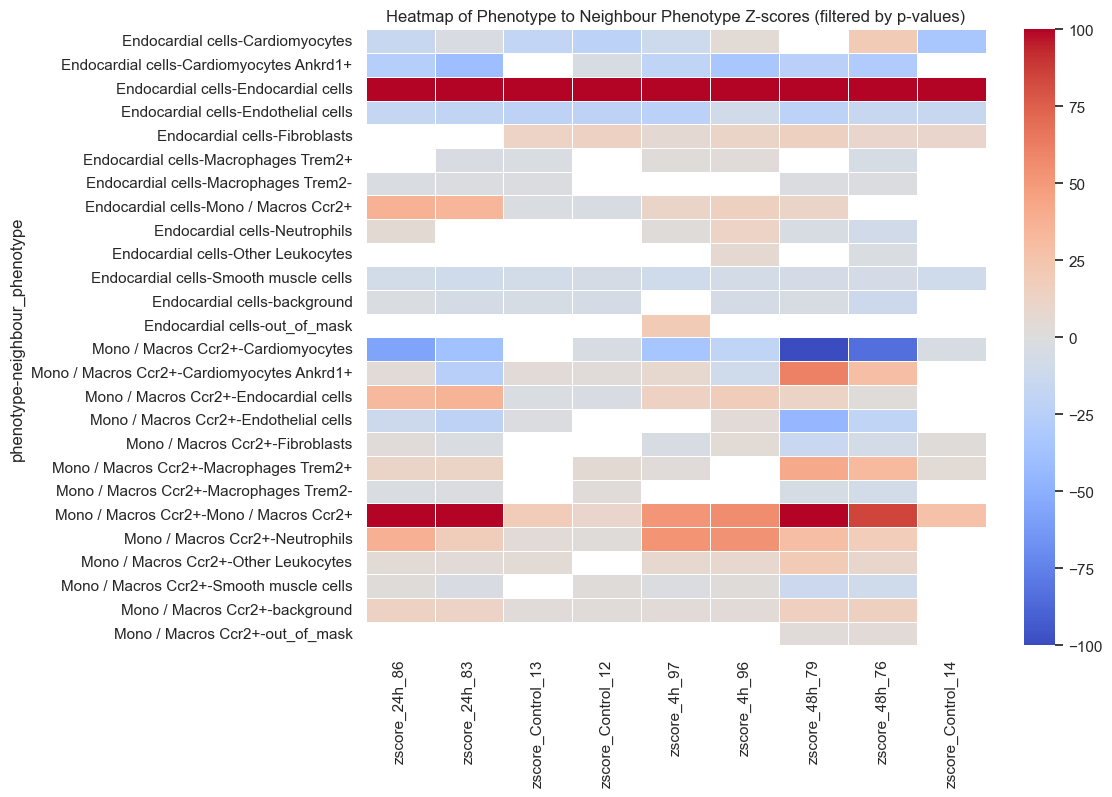

In [47]:
#
# make a heatmap from spatial.uns['dirSEA_rad30'] with phenotype to neighbor phenotype z-scores writing my own plotting function
df = spatial.uns['dirSEA_knn10_total']
# Set a p-value threshold for significance
pval_threshold = 0.05

# Example list of phenotypes you want to include in the heatmap
phenotypes_to_include = ['Endocardial cells', 'Mono / Macros Ccr2+']  # Update this list with your specific phenotypes


# Filter the z-scores based on p-values (set to NaN if p-value > threshold)
for col in df.columns:
    if col.startswith('zscore'):
        pval_col = col.replace('zscore', 'pvalue')
        df[col] = np.where(df[pval_col] <= pval_threshold, df[col], np.nan)

# Filter the DataFrame to only include the specified phenotypes
df_filtered = df[df['phenotype'].isin(phenotypes_to_include)]

# Pivot the dataframe to get a heatmap-friendly format
heatmap_data = df_filtered.set_index(['phenotype', 'neighbour_phenotype']).filter(like='zscore')

# Determine the min and max z-scores in the filtered data
vmin = -100 # set based on your dataset's minimum z-score
vmax = 100   # set based on your dataset's maximum z-score

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=.5, vmin=vmin, vmax=vmax)
plt.title('Heatmap of Phenotype to Neighbour Phenotype Z-scores (filtered by p-values)')
plt.show()

In [46]:
df

phenotype     neighbour_phenotype  zscore_24h_86  pvalue_24h_86  \
0    Cardiomyocytes          Cardiomyocytes     244.287942   0.000000e+00   
1    Cardiomyocytes  Cardiomyocytes Ankrd1+    -276.458662   0.000000e+00   
2    Cardiomyocytes       Endocardial cells     -20.198989   9.992198e-91   
3    Cardiomyocytes       Endothelial cells      32.749108  3.126296e-235   
4    Cardiomyocytes             Fibroblasts       3.423495   6.182131e-04   
..              ...                     ...            ...            ...   
164     out_of_mask             Neutrophils            NaN            NaN   
165     out_of_mask        Other Leukocytes            NaN            NaN   
166     out_of_mask     Smooth muscle cells            NaN            NaN   
167     out_of_mask              background            NaN            NaN   
168     out_of_mask             out_of_mask            NaN            NaN   

     zscore_24h_83  pvalue_24h_83  zscore_Control_13  pvalue_Control_13  \
0       262.920934   0.000000e+00          36.804893      1.541790e-296   
1      -285.952249   0.000000e+00          -5.452320       4.971692e-08   
2       -10.231898   1.426947e-24         -22.004778      2.591836e-107   
3        88.751849   0.000000e+00          -6.340395       2.291762e-10   
4        22.053174  8.905355e-108         -26.283057      2.995869e-152   
..             ...            ...                ...                ...   
164            NaN   5.944229e-01                NaN                NaN   
165            NaN   8.928416e-01                NaN                NaN   
166            NaN   6.975654e-01                NaN                NaN   
167            NaN   7.264893e-01                NaN                NaN   
168            NaN   1.000000e+00                NaN                NaN   

     zscore_Control_12  pvalue_Control_12  zscore_4h_97  pvalue_4h_97  \
0            72.645014       0.000000e+00    177.524964  0.000000e+00   
1           -31.910111      1.933229e-223   -171.565923  0.000000e+00   
2           -28.318212      2.062394e-176    -18.492694  2.364418e-76   
3           -28.982791      1.084254e-184      5.090799  3.565584e-07   
4           -39.030020       0.000000e+00    -15.626291  4.820609e-55   
..                 ...                ...           ...           ...   
164                NaN                NaN           NaN  4.719722e-01   
165                NaN                NaN           NaN  8.610941e-01   
166                NaN                NaN           NaN  5.505124e-01   
167                NaN                NaN           NaN  7.401441e-01   
168                NaN                NaN           NaN  1.000000e+00   

     zscore_4h_96  pvalue_4h_96  zscore_48h_79  pvalue_48h_79  zscore_48h_76  \
0      203.164488  0.000000e+00     192.945069   0.000000e+00     278.349668   
1     -225.641966  0.000000e+00    -194.364910   0.000000e+00    -174.576871   
2       -2.885808  3.904099e-03      -6.786124   1.151863e-11      11.241747   
3       16.917380  3.350039e-64      80.693610   0.000000e+00      49.388532   
4             NaN  1.381092e-01       5.835190   5.372946e-09            NaN   
..            ...           ...            ...            ...            ...   
164           NaN           NaN            NaN   5.546838e-01            NaN   
165           NaN           NaN            NaN   6.958775e-01       3.712264   
166           NaN           NaN            NaN   5.304270e-01            NaN   
167           NaN           NaN            NaN   2.914733e-01            NaN   
168           NaN           NaN            NaN   9.203443e-01            NaN   

     pvalue_48h_76  zscore_Control_14  pvalue_Control_14  
0     0.000000e+00          93.438631       0.000000e+00  
1     0.000000e+00          -9.297125       1.442944e-20  
2     2.542995e-29         -37.133146      8.202333e-302  
3     0.000000e+00         -37.164194      2.586151e-302  
4     5.436920e-02         -41.772559       0.00000